Loaded 99422 rows with 46 columns.
            player_name player_color     opponent_name  player_elo  \
0  Kupreichik, Viktor D        white      Tal, Mikhail      2540.0   
1           Keres, Paul        white      Tal, Mikhail         NaN   
2          Tal, Mikhail        white  Keene, Raymond D         NaN   
3        Klovans, Janis        white      Tal, Mikhail         NaN   
4          Tal, Mikhail        white        Benko, Pal         NaN   

         date  eco                                       opening_name  \
0  1979-12-01  B97  Sicilian Defense: Najdorf Variation, Poisoned ...   
1  1961-10-16  D30      Queen's Gambit Declined: Capablanca Variation   
2  1964-01-10  B15                 Caro-Kann Defense: Alekhine Gambit   
3  1951-01-01  C52     Italian Game: Evans Gambit, Sokolsky Variation   
4  1959-01-01  B27              Modern Defense: Pterodactyl Variation   

  player_type  game_id   result  ...  blunder_count  top_move_alignment  \
0         NaN        0  1/2-1/

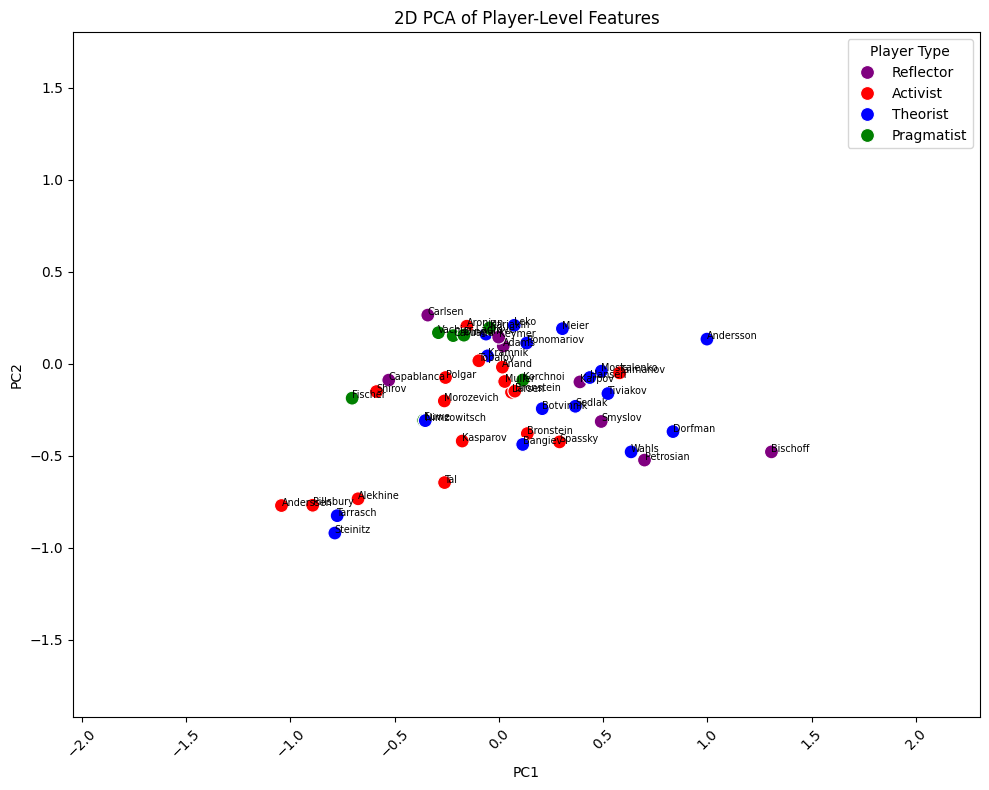

PCA (all features) explained variance ratios: [0.37423243 0.17988464 0.09914766]


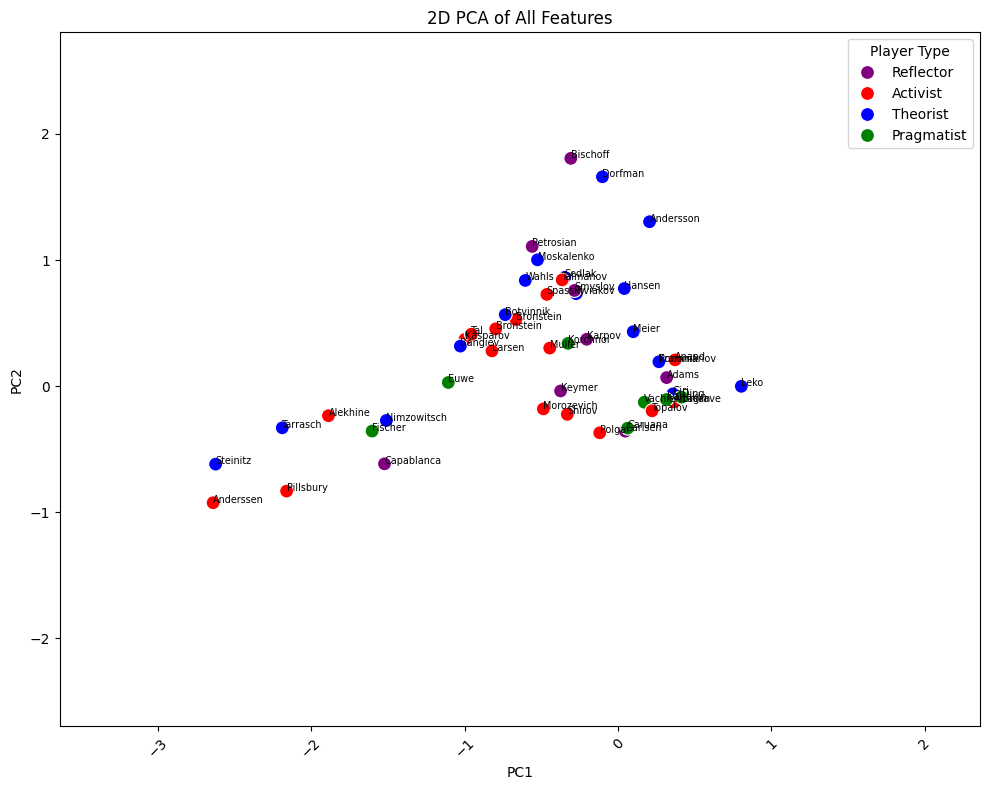

AUC for Activist: 0.7407407407407408
AUC for Pragmatist: 0.423076923076923
AUC for Reflector: 0.3076923076923077
AUC for Theorist: 0.76
Mean AUC Score (Decision Boundary Score): 0.5578774928774929


In [9]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
from scipy import stats

from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve

import warnings
warnings.filterwarnings('ignore')

# -------------------------------
# Step 1. Aggregate Game-Level Data to Player Level
# -------------------------------
def aggregate_player_data(players_df, min_games=3):
    """
    Aggregate game-level data into a player-level DataFrame.
    Only players with at least `min_games` games are included.
    Averages are computed for numeric features.
    'None' player types are replaced with 'Unknown'.
    Added: ECO rates, win/draw/lose rates, and outlier removal.
    """
    # Identify players with enough games
    game_counts = players_df['player_name'].value_counts()
    players_with_enough_games = game_counts[game_counts >= min_games].index.tolist()
    print(f"Found {len(players_with_enough_games)} players with at least {min_games} games.")

    # Filter to these players
    filtered_df = players_df[players_df['player_name'].isin(players_with_enough_games)].copy()

    # Columns that we will ignore for numeric aggregation
    ignore_cols = ['player_name', 'player_color', 'opponent_name', 'game_id', 'result', 'player_type', 'date', 'total_moves']
    numeric_cols = [col for col in filtered_df.columns
                    if col not in ignore_cols and pd.api.types.is_numeric_dtype(filtered_df[col])]
    
    # Impute missing values based on the mean of each player
    filtered_df[numeric_cols] = filtered_df.groupby('player_name')[numeric_cols].transform(lambda x: x.fillna(x.mean()))
    
    aggregated_data = []

    for player in players_with_enough_games:
        player_games = filtered_df[filtered_df['player_name'] == player].copy()
        
        # Get the first non-NaN player_type if available, default to 'Unknown'
        if 'player_type' in player_games.columns:
            p_type_series = player_games['player_type'].dropna()
            p_type = p_type_series.iloc[0] if not p_type_series.empty else 'Unknown'
        else:
            p_type = 'Unknown'
            
        # # STEP 1: Remove outlier games
        # if len(player_games) >= 5:  # Only attempt outlier removal if we have enough games
        #     # Create a style fingerprint for each game based on key metrics
        #     style_cols = ['top_move_alignment', 'top2_3_move_alignment', 'opening_length', 
        #                  'middlegame_length', 'endgame_length', 'material_balance_std']
            
        #     # Make sure we only use columns that exist and are truly numeric
        #     valid_style_cols = []
        #     for col in style_cols:
        #         if col in player_games.columns:
        #             # Check if the column is numeric and has no strings
        #             try:
        #                 # Convert to numeric, coercing errors to NaN
        #                 player_games[col] = pd.to_numeric(player_games[col], errors='coerce')
        #                 # Only include the column if it has valid numeric values
        #                 if not player_games[col].isna().all():
        #                     valid_style_cols.append(col)
        #             except:
        #                 print(f"Warning: Could not convert column {col} to numeric for player {player}")
            
        #     if valid_style_cols:
        #         # Calculate Z-scores for each valid style metric
        #         for col in valid_style_cols:
        #             # Skip calculation if standard deviation is zero or column has NaNs
        #             if player_games[col].std() > 0 and not player_games[col].isna().any():
        #                 player_games[f'{col}_zscore'] = np.abs((player_games[col] - player_games[col].mean()) / player_games[col].std())
                
        #         # Calculate mean Z-score across all metrics for each game
        #         zscore_cols = [f'{col}_zscore' for col in valid_style_cols if f'{col}_zscore' in player_games.columns]
        #         if zscore_cols:
        #             player_games['style_deviation'] = player_games[zscore_cols].mean(axis=1)
                    
        #             # Identify outliers (games with style_deviation > 2)
        #             outliers = player_games[player_games['style_deviation'] > 2]
                    
        #             if len(outliers) > 0:
        #                 print(f"Removing {len(outliers)} outlier games for {player} (keeping {len(player_games) - len(outliers)})")
        #                 player_games = player_games[player_games['style_deviation'] <= 2]
        
        # Initialize player statistics
        player_stats = {
            'player_name': player,
            'player_type': p_type,
            'num_games': len(player_games)
        }
        
        # STEP 2: Add ECO rates (opening categories)
        if 'eco' in player_games.columns:
            # Extract the main ECO category (first letter: A, B, C, D, E)
            player_games['eco_category'] = player_games['eco'].astype(str).str[0]
            
            # Calculate frequency of each category
            eco_counts = player_games['eco_category'].value_counts(normalize=True)
            
            # Add each ECO category frequency
            for category in ['A', 'B', 'C', 'D', 'E']:
                player_stats[f'eco_{category}_rate'] = eco_counts.get(category, 0.0)
                
            # Add diversity of openings metric
            player_stats['opening_diversity'] = len(player_games['eco'].unique()) / len(player_games)
        
        # STEP 3: Add win/draw/loss rates
        if 'result' in player_games.columns and 'player_color' in player_games.columns:
            # Overall statistics
            player_stats['win_rate'] = ((player_games['player_color'] == 'white') & (player_games['result'] == '1-0') | 
                                       (player_games['player_color'] == 'black') & (player_games['result'] == '0-1')).mean()
            
            player_stats['draw_rate'] = (player_games['result'] == '1/2-1/2').mean()
            
            player_stats['loss_rate'] = ((player_games['player_color'] == 'white') & (player_games['result'] == '0-1') | 
                                        (player_games['player_color'] == 'black') & (player_games['result'] == '1-0')).mean()
            
            # White statistics
            white_games = player_games[player_games['player_color'] == 'white']
            if len(white_games) > 0:
                player_stats['white_game_rate'] = len(white_games) / len(player_games)
                player_stats['white_win_rate'] = (white_games['result'] == '1-0').mean()
                player_stats['white_draw_rate'] = (white_games['result'] == '1/2-1/2').mean()
                player_stats['white_loss_rate'] = (white_games['result'] == '0-1').mean()
            else:
                player_stats['white_game_rate'] = 0
                player_stats['white_win_rate'] = 0
                player_stats['white_draw_rate'] = 0
                player_stats['white_loss_rate'] = 0
            
            # Black statistics
            black_games = player_games[player_games['player_color'] == 'black']
            if len(black_games) > 0:
                player_stats['black_game_rate'] = len(black_games) / len(player_games)
                player_stats['black_win_rate'] = (black_games['result'] == '0-1').mean()
                player_stats['black_draw_rate'] = (black_games['result'] == '1/2-1/2').mean()
                player_stats['black_loss_rate'] = (black_games['result'] == '1-0').mean()
            else:
                player_stats['black_game_rate'] = 0
                player_stats['black_win_rate'] = 0
                player_stats['black_draw_rate'] = 0
                player_stats['black_loss_rate'] = 0
        
        # STEP 4: Compute original averages for each numeric feature (as in the original code)
        for col in numeric_cols:
            # Ensure the column is numeric before calculating mean
            try:
                # Convert to numeric, coercing errors to NaN
                numeric_values = pd.to_numeric(player_games[col], errors='coerce')
                # Only calculate mean if we have valid numeric values
                if not numeric_values.isna().all():
                    player_stats[col] = numeric_values.mean()
                else:
                    player_stats[col] = np.nan
            except:
                player_stats[col] = np.nan
            
        aggregated_data.append(player_stats)

    agg_df = pd.DataFrame(aggregated_data)
    
    # Report feature count
    feature_count = len(agg_df.columns) - 3  # Subtract player_name, player_type, num_games
    print(f"Created {feature_count} features for each player")
    
    return agg_df

# -------------------------------
# Step 2. Select Best Features using RandomForest Importance
# -------------------------------
def select_best_features(agg_df, n_features=15, importance_threshold=0.1):
    """
    Select best numeric features using RandomForestClassifier importance
    with 'player_type' as the target.
    """
    metadata = ['player_name', 'player_type', 'num_games']
    print(f"Selecting best features from {len(agg_df)} players with {len(agg_df.columns)} columns.")
    print(f"All features: {agg_df.columns.tolist()}")
    numeric_cols = [col for col in agg_df.columns if col not in metadata and pd.api.types.is_numeric_dtype(agg_df[col])]


    # drop unknown players
    agg_df = agg_df[agg_df['player_type'] != 'Unknown']
    # reset index to avoid KeyError when accessing rows by position
    agg_df = agg_df.reset_index(drop=True)
   
    X = agg_df[numeric_cols]
    y = agg_df['player_type']
    



    # Encode player_type as numeric
    le = LabelEncoder()
    y_encoded = le.fit_transform(y)

    # Impute and scale
    # Impute missing values based on the mean of each player
    X = X.groupby(agg_df['player_name']).transform(lambda x: x.fillna(x.mean()))
    imputer = SimpleImputer(strategy='mean')
    scaler = MinMaxScaler()
    X_imputed = imputer.fit_transform(X)
    X_scaled = scaler.fit_transform(X_imputed)

    # Train RandomForest classifier
    rf = RandomForestClassifier(n_estimators=2500, random_state=42)
    rf.fit(X_scaled, y_encoded)

    importances = rf.feature_importances_
    importance_series = pd.Series(importances, index=numeric_cols)

    # Normalize importances to the maximum value
    importance_series = importance_series / importance_series.max()

    # Select features above the importance threshold
    selected = importance_series[importance_series > importance_threshold].index.tolist()

    # If more than desired n_features, choose the top n_features based on importance
    if len(selected) > n_features:
        selected = importance_series.sort_values(ascending=False).index[:n_features].tolist()

    print("Selected features:", selected)
    return selected

# -------------------------------
# Step 3. Apply PCA to Selected Features
# -------------------------------
def apply_pca(agg_df, features, n_components=3):
    """
    Scale the selected features, apply PCA and return the transformed data.
    """
    X = agg_df[features]
    # Impute missing values based on the mean of each player
    X = X.groupby(agg_df['player_name']).transform(lambda x: x.fillna(x.mean()))
    imputer = SimpleImputer(strategy='mean')
    scaler = MinMaxScaler()

    X_imputed = imputer.fit_transform(X)
    X_scaled = scaler.fit_transform(X_imputed)

    pca = PCA(n_components=n_components, random_state=42)
    X_pca = pca.fit_transform(X_scaled)

    print(f"PCA explained variance ratios: {pca.explained_variance_ratio_}")
    return X_pca, pca

def apply_pca_all_features(agg_df, n_components=2):
    """
    Apply PCA to all numeric features (without any feature selection)
    for a 2D visualization.
    """
    metadata = ['player_name', 'player_type', 'num_games']
    numeric_cols = [col for col in agg_df.columns 
                    if col not in metadata and pd.api.types.is_numeric_dtype(agg_df[col])]
    
    X = agg_df[numeric_cols]
    X = X.groupby(agg_df['player_name']).transform(lambda x: x.fillna(x.mean()))
    imputer = SimpleImputer(strategy='mean')
    scaler = MinMaxScaler()
    X_imputed = imputer.fit_transform(X)
    X_scaled = scaler.fit_transform(X_imputed)
    
    pca = PCA(n_components=n_components, random_state=42)
    X_pca = pca.fit_transform(X_scaled)
    print(f"PCA (all features) explained variance ratios: {pca.explained_variance_ratio_}")
    return X_pca, pca

# -------------------------------
# Step 4. Visualize 2D PCA Result using Seaborn
# -------------------------------
def visualize_2d_pca(agg_df, X_pca_2d, title='2D PCA of Player-Level Features'):
    """
    Visualize 2D PCA result using a scatter plot.
    Points are colored by player_type and labeled by player_name.
    """
    pca_df = pd.DataFrame({
        'PC1': X_pca_2d[:, 0],
        'PC2': X_pca_2d[:, 1],
        'player_type': agg_df['player_type'], # Should now contain 'Unknown' instead of None
        'player_name': agg_df['player_name']
    })
    
    # Filter out unknown players AFTER creating the dataframe with all the data
    pca_df = pca_df[pca_df['player_type'] != 'Unknown']
    
    # hide activist 
    # pca_df = pca_df[pca_df['player_type'] != 'Activist']
    
    # hide pragmatist
    # pca_df = pca_df[pca_df['player_type'] != 'Pragmatist']
    
    # hide reflector
    # pca_df = pca_df[pca_df['player_type'] != 'Reflector']
    
    # hide theorist
    # pca_df = pca_df[pca_df['player_type'] != 'Theorist']
    
    # Reset the index to avoid KeyError when accessing rows by position
    pca_df = pca_df.reset_index(drop=True)

    plt.figure(figsize=(10, 8))
    # Define the palette, using 'Unknown' as the key for gray
    palette = {
        'Activist': 'red',
        'Theorist': 'blue',
        'Pragmatist': 'green',
        'Reflector': 'purple',
        'Unknown': 'gray' # Changed None key to 'Unknown'
    }
    ax = sns.scatterplot(data=pca_df, x='PC1', y='PC2', hue='player_type',
                         palette=palette, s=100)

    # Add labels for each point
    for line in range(0,pca_df.shape[0]):
         player_name = pca_df.player_name[line]
         if ', ' in player_name:
             last_name = player_name.split(', ')[0]
             ax.text(pca_df.PC1[line], pca_df.PC2[line], last_name, horizontalalignment='left', size='x-small', color='black')
         else:
             ax.text(pca_df.PC1[line], pca_df.PC2[line], player_name, horizontalalignment='left', size='x-small', color='black')

    plt.title(title)
    plt.xlabel('PC1')
    plt.ylabel('PC2')
    plt.legend(title='Player Type')
    plt.xlim(X_pca_2d[:, 0].min() - 1, X_pca_2d[:, 0].max() + 1)
    plt.ylim(X_pca_2d[:, 1].min() - 1, X_pca_2d[:, 1].max() + 1)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# -------------------------------
# Step 5. Create Interactive 3D PCA Visualization using Plotly Express
# -------------------------------
def visualize_3d_pca(agg_df, X_pca_3d):
    """
    Create an interactive 3D scatter plot of the PCA result using Plotly Express.
    Points are colored by player_type.
    """
    pca_df = pd.DataFrame({
        'PC1': X_pca_3d[:, 0],
        'PC2': X_pca_3d[:, 1],
        'PC3': X_pca_3d[:, 2],
        'player_type': agg_df['player_type'], # Should now contain 'Unknown' instead of None
        'player_name': agg_df['player_name']
    })

    # Define the color map, using 'Unknown' as the key for gray
    color_map = {
        'Activist': 'red',
        'Theorist': 'blue',
        'Pragmatist': 'green',
        'Reflector': 'purple',
        'Unknown': 'gray'  # Changed None key to 'Unknown'
    }

    fig = px.scatter_3d(
        pca_df,
        x='PC1', y='PC2', z='PC3',
        color='player_type',
        hover_data=['player_name'],
        color_discrete_map=color_map,
        title='Interactive 3D PCA of Player-Level Features'
    )
    fig.update_traces(marker=dict(size=5))
    fig.show()

# -------------------------------
# Step 6. Decision Boundary Score (AUC)
# -------------------------------
def calculate_decision_boundary_score(agg_df):
    """
    Calculates the Area Under the ROC Curve (AUC) for a RandomForestClassifier
    predicting player_type.  Uses the selected features from the
    select_best_features function.  Prints AUC for each class and the mean AUC.
    """

    # Prepare data
    agg_df = agg_df.copy()
    
    # Skip unknown players
    agg_df = agg_df[agg_df['player_type'] != 'Unknown']
    
    le = LabelEncoder()
    agg_df['player_type'] = le.fit_transform(agg_df['player_type'])  # Numerical labels

    # Select features (using the same logic as before)
    metadata = ['player_name', 'player_type', 'num_games']
    numeric_cols = [col for col in agg_df.columns if col not in metadata and pd.api.types.is_numeric_dtype(agg_df[col])]

    X = agg_df[numeric_cols]
    y = agg_df['player_type']
    
    # Impute missing values based on the mean of each player
    X = X.groupby(agg_df['player_name']).transform(lambda x: x.fillna(x.mean()))

    # Impute and Scale
    imputer = SimpleImputer(strategy='mean')
    scaler = MinMaxScaler()
    X_imputed = imputer.fit_transform(X)
    X_scaled = scaler.fit_transform(X_imputed)

    # Train/Test split
    X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42)

    # Train RandomForestClassifier
    rf_classifier = RandomForestClassifier(n_estimators=5000, random_state=42)
    rf_classifier.fit(X_train, y_train)

    # Predict probabilities
    y_pred_proba = rf_classifier.predict_proba(X_test)

    # Calculate AUC (one-vs-rest for multiclass)
    auc_scores = {}
    for i in range(len(le.classes_)):
        try:
            auc = roc_auc_score(y_test == i, y_pred_proba[:, i])
            auc_scores[le.inverse_transform([i])[0]] = auc
            print(f"AUC for {le.inverse_transform([i])[0]}: {auc}")
        except ValueError as e:
            class_name = le.inverse_transform([i])[0]
            print(f"ValueError calculating AUC for class {class_name}: {e}")
            auc_scores[class_name] = 0.5  # Assign a neutral value if AUC cannot be computed

    mean_auc = np.mean(list(auc_scores.values()))

    print(f"Mean AUC Score (Decision Boundary Score): {mean_auc}")
    return mean_auc


# -------------------------------
# Main Function
# -------------------------------
def main():
    # Load the game-level data
    input_file = 'player_centric_data.csv'  # Adjust the file path as necessary
    df = pd.read_csv(input_file)
    print(f"Loaded {len(df)} rows with {len(df.columns)} columns.")
    print(df.head())

    # Aggregate to player level (using a minimum game threshold, e.g., 100)
    # This will now replace None player_types with 'Unknown'
    agg_df = aggregate_player_data(df, min_games=100)

    # Select best features based on importance
    selected_features = select_best_features(agg_df, n_features=15, importance_threshold=0.1)

    # Apply PCA for 3 components
    X_pca, pca_model = apply_pca(agg_df, selected_features, n_components=3)

    # Visualize the first 2 components (2D PCA)
    # The palette now correctly maps 'Unknown' to gray
    visualize_2d_pca(agg_df, X_pca[:, :2])

    # Create an interactive 3D PCA visualization
    # The color map now correctly maps 'Unknown' to gray
    # visualize_3d_pca(agg_df, X_pca)
    
    
    # apply PCA to all features for 2D visualization
    X_pca_all, pca_model_all = apply_pca_all_features(agg_df, n_components=3)
    visualize_2d_pca(agg_df, X_pca_all[:, :2], title='2D PCA of All Features')
    # Create an interactive 3D PCA visualization for all features
    # visualize_3d_pca(agg_df, X_pca_all)

    # Calculate and print decision boundary score (AUC)
    calculate_decision_boundary_score(agg_df)

if __name__ == "__main__":
    main()

Loaded 99422 rows with 46 columns.
Found 96 players with at least 100 games.
Created 52 features for each player

Assigned player types for 1 players from provided lists
Assigned eras for 48 players

Player Era Categorization:
  Unknown Era: 48 players
  Computer Age: 30 players
  Pre-Computer Age: 18 players

Player Types in Computer Age:
  Theorist: 14 players
  Activist: 7 players
  Reflector: 5 players
  Pragmatist: 4 players

Player Types in Pre-Computer Age:
  Activist: 8 players
  Theorist: 4 players
  Pragmatist: 3 players
  Reflector: 3 players

Player Types in Unknown Era:
  Unknown: 46 players
  Activist: 2 players

ANALYSIS WITH SELECTED FEATURES

Selected features: ['space_advantage', 'material_changes', 'top2_3_move_alignment', 'endgame_length', 'eco_B_rate', 'brilliant_count', 'vulnerability_spikes', 'center_control_avg', 'check_frequency', 'sharpness', 'middlegame_length', 'sacrifice_count', 'piece_mobility_avg', 'minor_piece_development', 'king_safety']

PCA on Selecte

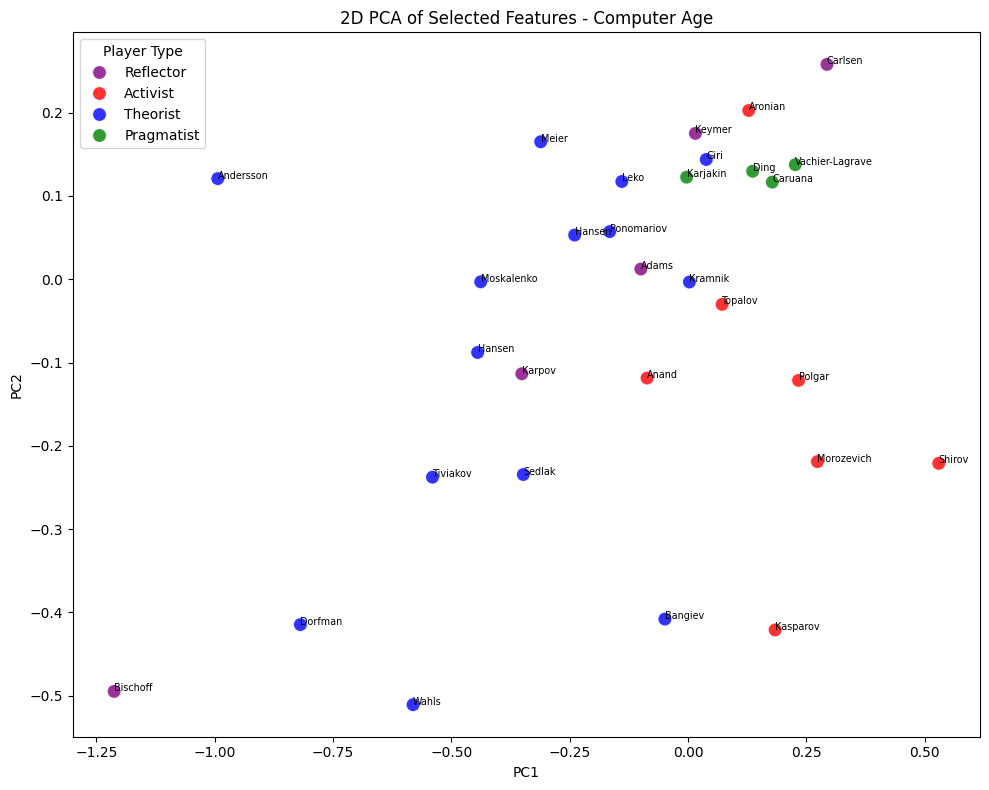

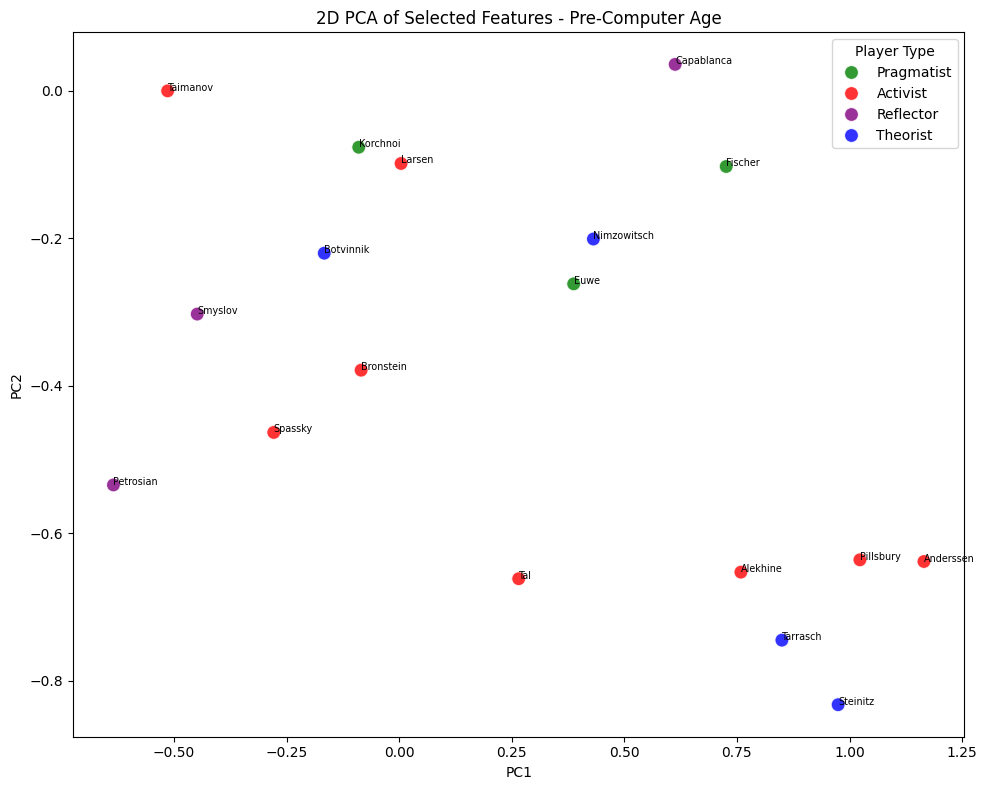

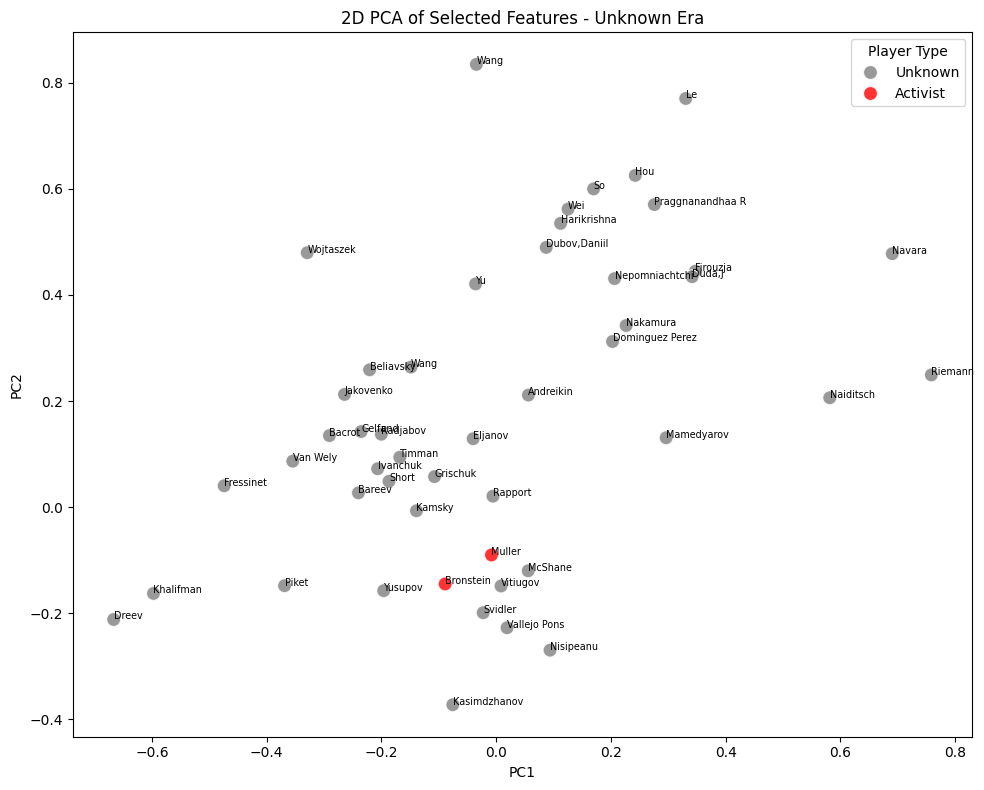

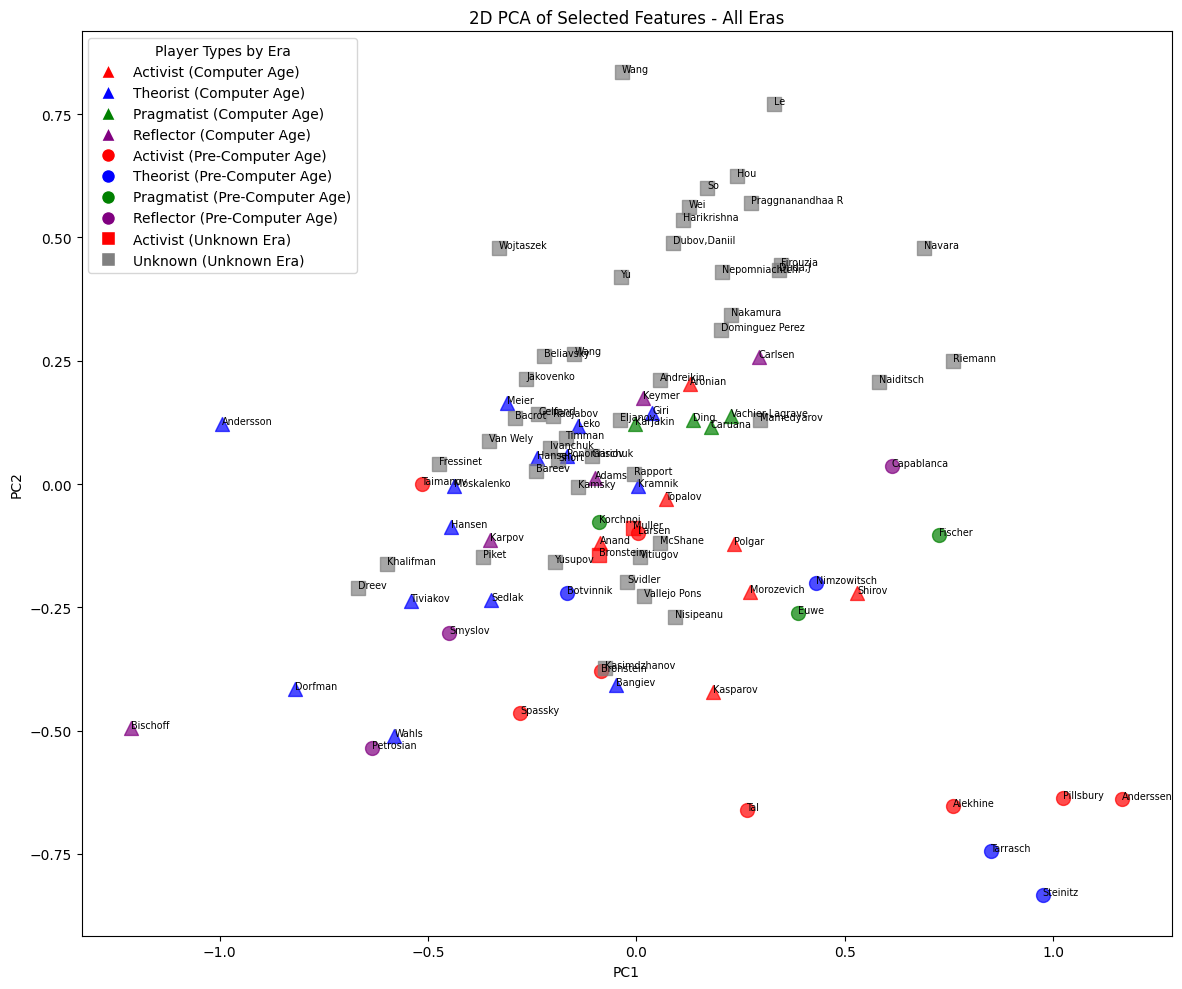


Calculating Decision Boundary Score with Selected Features:
Number of features used: 15

Decision Boundary Score for Computer Age:
  AUC for Activist: 0.7857
  AUC for Pragmatist: 0.2500
  AUC for Reflector: 0.6429
  AUC for Theorist: 0.9000
  Mean AUC Score for Computer Age: 0.6446

Decision Boundary Score for Pre-Computer Age:
  AUC for Activist: 0.7222
  AUC for Pragmatist: 0.2000
  AUC for Reflector: 1.0000
  AUC for Theorist: 0.7000
  Mean AUC Score for Pre-Computer Age: 0.6556

Decision Boundary Score for Unknown Era:
  AUC for Activist: 1.0000
  AUC for Unknown: 1.0000
  Mean AUC Score for Unknown Era: 1.0000

Calculating Combined Decision Boundary Score with Selected Features:
  AUC for Activist: 0.6458
  AUC for Pragmatist: 0.4722
  AUC for Reflector: 0.7963
  AUC for Theorist: 0.5688
  AUC for Unknown: 0.8000
Combined Mean AUC Score with Selected Features: 0.6566

ANALYSIS WITH ALL FEATURES

PCA on All Features:
Number of features used: 52
Explained variance ratios: [0.37494

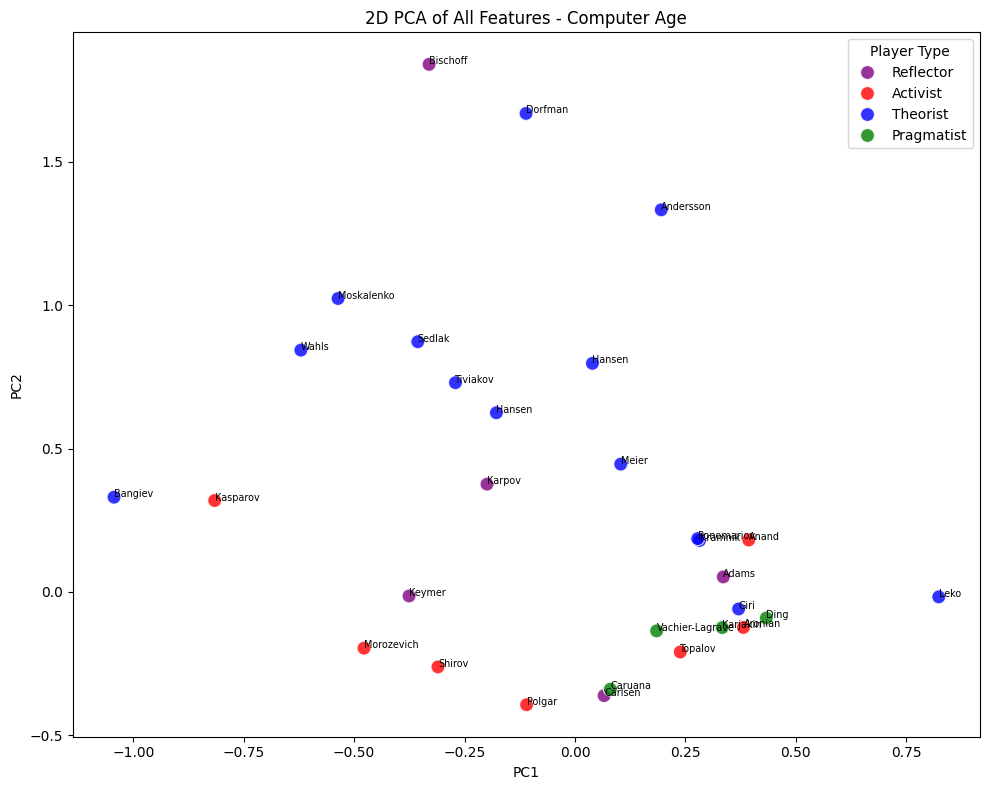

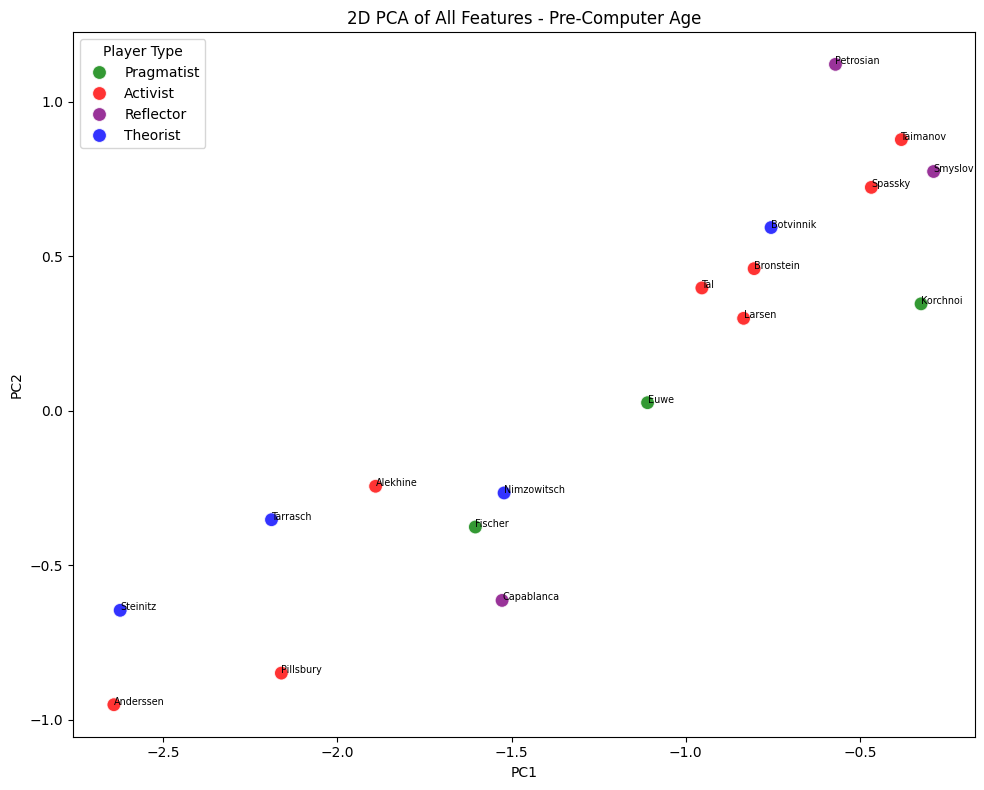

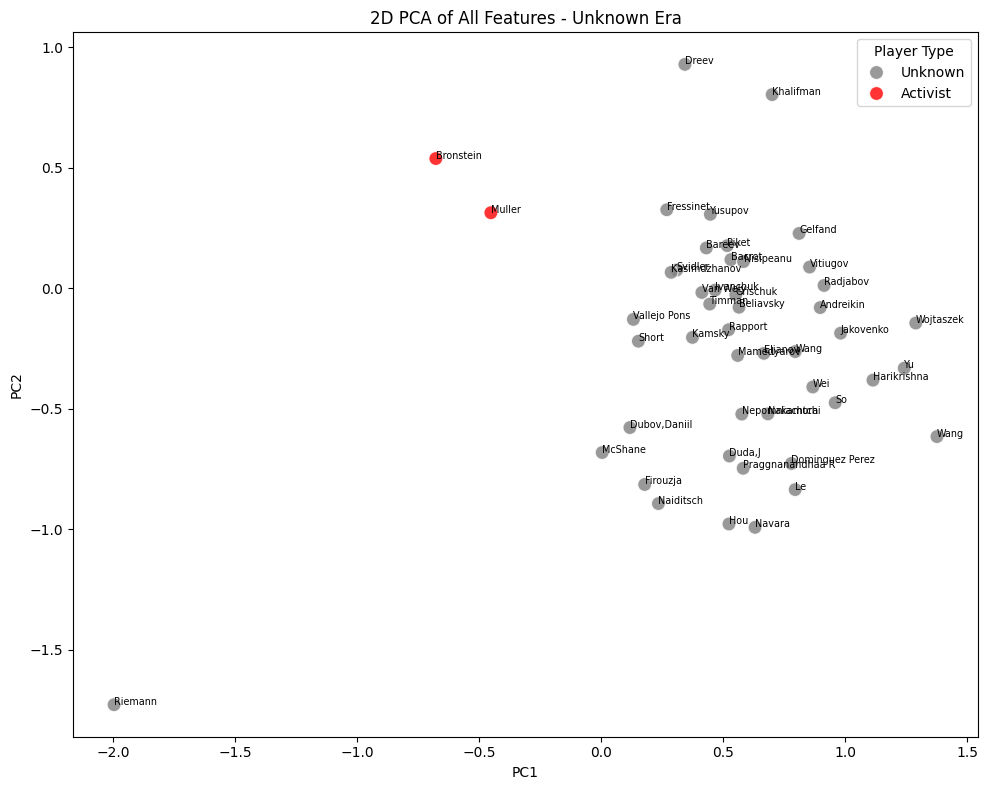

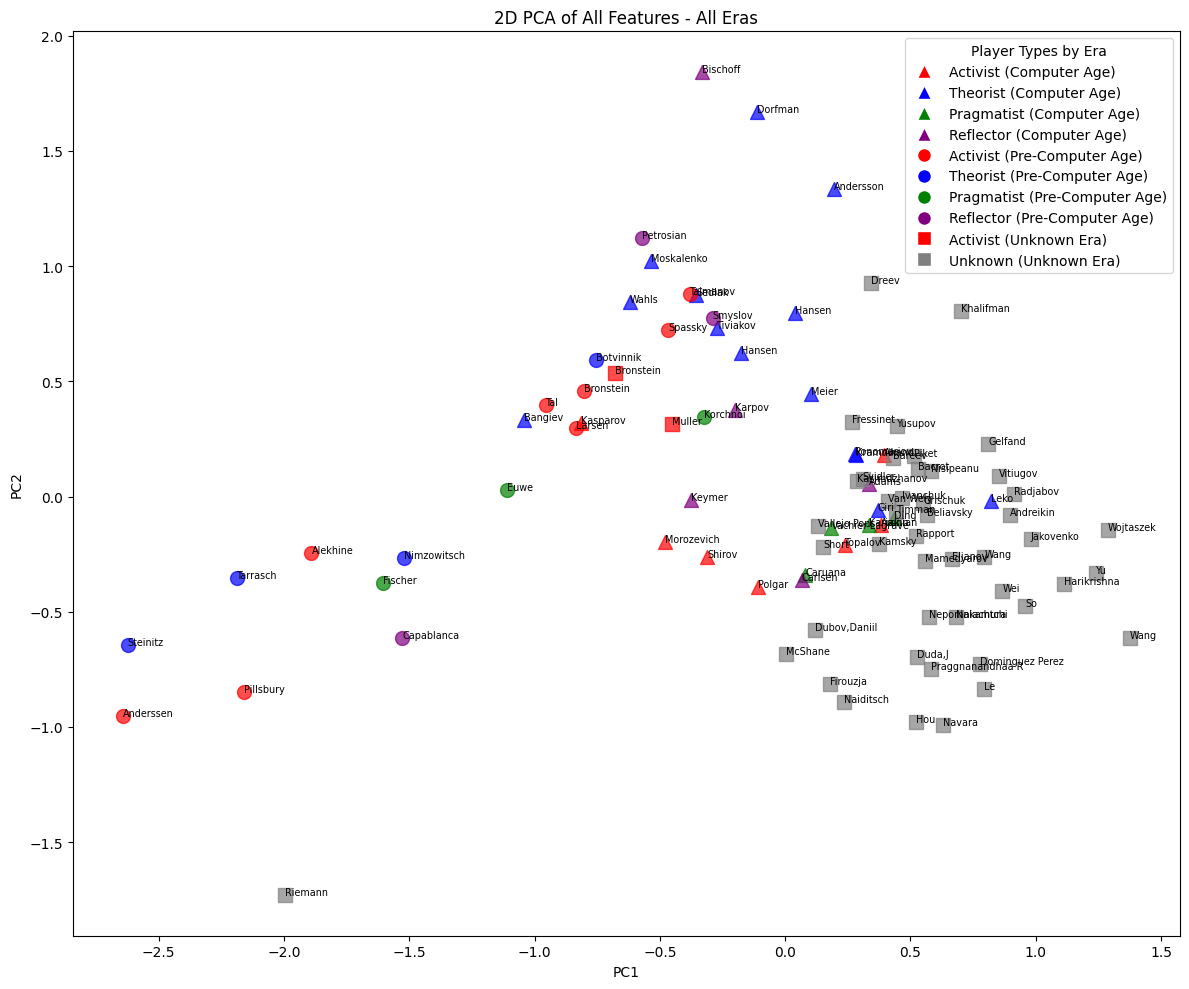


Calculating Decision Boundary Score with All Features:
Number of features used: 52

Decision Boundary Score for Computer Age:
  AUC for Activist: 0.6071
  AUC for Pragmatist: 0.3125
  AUC for Reflector: 0.4286
  AUC for Theorist: 0.8500
  Mean AUC Score for Computer Age: 0.5496

Decision Boundary Score for Pre-Computer Age:
  AUC for Activist: 0.3333
  AUC for Pragmatist: 0.0000
  AUC for Reflector: 1.0000
  AUC for Theorist: 0.8000
  Mean AUC Score for Pre-Computer Age: 0.5333

Decision Boundary Score for Unknown Era:
  AUC for Activist: 1.0000
  AUC for Unknown: 1.0000
  Mean AUC Score for Unknown Era: 1.0000

Calculating Combined Decision Boundary Score with All Features:
  AUC for Activist: 0.7583
  AUC for Pragmatist: 0.9074
  AUC for Reflector: 0.6667
  AUC for Theorist: 0.7065
  AUC for Unknown: 1.0000
Combined Mean AUC Score with All Features: 0.8078

COMPARISON OF RESULTS
AUC with Selected Features (15 features): 0.6566
AUC with All Features (52 features): 0.8078
Difference: 

In [14]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px

from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

import warnings
warnings.filterwarnings('ignore')

# -------------------------------
# Define Known Player Types by Era
# -------------------------------
activist_pre_computer = [
    "Alekhine", "Tal", "Spassky", "Pillsbury",
    "Anderssen", "Bronstein, David", "Larsen", "Taimanov"
]

activist_computer_age = [
    "Kasparov", "Anand", "Shirov", "Morozevich",
    "Topalov", "Aronian", "Polgar", "Müller"
]

theorist_pre_computer = [
    "Steinitz", "Botvinnik", "Tarrasch", "Nimzowitsch"
]

theorist_computer_age = [
    "Kramnik", "Leko", "Giri", "Meier", "Andersson",
    "Sedlak", "Tiviakov", "Ponomariov", "Wahls",
    "Moskalenko", "Dorfman", "Bangiev", "Hansen"
]

reflector_pre_computer = [
    "Capablanca", "Smyslov", "Petrosian"
]

reflector_computer_age = [
    "Karpov", "Carlsen", "Adams, Michael", "Keymer", "Bischoff"
]

pragmatist_pre_computer = [
    "Fischer", "Euwe", "Korchnoi"
]

pragmatist_computer_age = [
    "Caruana", "Ding", "Karjakin", "Vachier-Lagrave"
]

# -------------------------------
# Step 1. Aggregate Game-Level Data to Player Level
# -------------------------------
def aggregate_player_data(players_df, min_games=3):
    """
    Aggregate game-level data into a player-level DataFrame.
    Only players with at least `min_games` games are included.
    Averages are computed for numeric features.
    'None' player types are replaced with 'Unknown'.
    Added: ECO rates, win/draw/lose rates, and outlier removal.
    """
    # Identify players with enough games
    game_counts = players_df['player_name'].value_counts()
    players_with_enough_games = game_counts[game_counts >= min_games].index.tolist()
    print(f"Found {len(players_with_enough_games)} players with at least {min_games} games.")

    # Filter to these players
    filtered_df = players_df[players_df['player_name'].isin(players_with_enough_games)].copy()

    # Columns that we will ignore for numeric aggregation
    ignore_cols = ['player_name', 'player_color', 'opponent_name', 'game_id', 'result', 'player_type', 'date', 'total_moves']
    numeric_cols = [col for col in filtered_df.columns
                    if col not in ignore_cols and pd.api.types.is_numeric_dtype(filtered_df[col])]
    
    # Impute missing values based on the mean of each player
    filtered_df[numeric_cols] = filtered_df.groupby('player_name')[numeric_cols].transform(lambda x: x.fillna(x.mean()))
    
    aggregated_data = []

    for player in players_with_enough_games:
        player_games = filtered_df[filtered_df['player_name'] == player].copy()
        
        # Get the first non-NaN player_type if available, default to 'Unknown'
        if 'player_type' in player_games.columns:
            p_type_series = player_games['player_type'].dropna()
            p_type = p_type_series.iloc[0] if not p_type_series.empty else 'Unknown'
        else:
            p_type = 'Unknown'
            
        
        # Initialize player statistics
        player_stats = {
            'player_name': player,
            'player_type': p_type,
            'num_games': len(player_games)
        }
        
        # STEP 2: Add ECO rates (opening categories)
        if 'eco' in player_games.columns:
            # Extract the main ECO category (first letter: A, B, C, D, E)
            player_games['eco_category'] = player_games['eco'].astype(str).str[0]
            
            # Calculate frequency of each category
            eco_counts = player_games['eco_category'].value_counts(normalize=True)
            
            # Add each ECO category frequency
            for category in ['A', 'B', 'C', 'D', 'E']:
                player_stats[f'eco_{category}_rate'] = eco_counts.get(category, 0.0)
                
            # Add diversity of openings metric
            player_stats['opening_diversity'] = len(player_games['eco'].unique()) / len(player_games)
        
        # STEP 3: Add win/draw/loss rates
        if 'result' in player_games.columns and 'player_color' in player_games.columns:
            # Overall statistics
            player_stats['win_rate'] = ((player_games['player_color'] == 'white') & (player_games['result'] == '1-0') | 
                                       (player_games['player_color'] == 'black') & (player_games['result'] == '0-1')).mean()
            
            player_stats['draw_rate'] = (player_games['result'] == '1/2-1/2').mean()
            
            player_stats['loss_rate'] = ((player_games['player_color'] == 'white') & (player_games['result'] == '0-1') | 
                                        (player_games['player_color'] == 'black') & (player_games['result'] == '1-0')).mean()
            
            # White statistics
            white_games = player_games[player_games['player_color'] == 'white']
            if len(white_games) > 0:
                player_stats['white_game_rate'] = len(white_games) / len(player_games)
                player_stats['white_win_rate'] = (white_games['result'] == '1-0').mean()
                player_stats['white_draw_rate'] = (white_games['result'] == '1/2-1/2').mean()
                player_stats['white_loss_rate'] = (white_games['result'] == '0-1').mean()
            else:
                player_stats['white_game_rate'] = 0
                player_stats['white_win_rate'] = 0
                player_stats['white_draw_rate'] = 0
                player_stats['white_loss_rate'] = 0
            
            # Black statistics
            black_games = player_games[player_games['player_color'] == 'black']
            if len(black_games) > 0:
                player_stats['black_game_rate'] = len(black_games) / len(player_games)
                player_stats['black_win_rate'] = (black_games['result'] == '0-1').mean()
                player_stats['black_draw_rate'] = (black_games['result'] == '1/2-1/2').mean()
                player_stats['black_loss_rate'] = (black_games['result'] == '1-0').mean()
            else:
                player_stats['black_game_rate'] = 0
                player_stats['black_win_rate'] = 0
                player_stats['black_draw_rate'] = 0
                player_stats['black_loss_rate'] = 0
        
        # STEP 4: Compute original averages for each numeric feature (as in the original code)
        for col in numeric_cols:
            # Ensure the column is numeric before calculating mean
            try:
                # Convert to numeric, coercing errors to NaN
                numeric_values = pd.to_numeric(player_games[col], errors='coerce')
                # Only calculate mean if we have valid numeric values
                if not numeric_values.isna().all():
                    player_stats[col] = numeric_values.mean()
                else:
                    player_stats[col] = np.nan
            except:
                player_stats[col] = np.nan
            
        aggregated_data.append(player_stats)

    agg_df = pd.DataFrame(aggregated_data)
    
    # Report feature count
    feature_count = len(agg_df.columns) - 3  # Subtract player_name, player_type, num_games
    print(f"Created {feature_count} features for each player")
    
    return agg_df

# -------------------------------
# Step 2. Categorize Players into Pre-Computer and Computer Age Eras
# -------------------------------
def categorize_players_by_era(agg_df):
    """
    Categorize players into "Pre-Computer Age" and "Computer Age" based on
    their presence in the known player lists.
    """
    # Add era column, default to 'Unknown Era'
    agg_df['era'] = 'Unknown Era'
    
    # For tracking assignment stats
    assigned_type_count = 0
    assigned_era_count = 0
    
    # Categorize players by type and era
    for idx, player in agg_df.iterrows():
        player_name = player['player_name']
        original_type = player['player_type']
        
        # Check all known player categories
        if any(name in player_name for name in activist_pre_computer):
            agg_df.at[idx, 'player_type'] = 'Activist'
            agg_df.at[idx, 'era'] = 'Pre-Computer Age'
            if original_type == 'Unknown':
                assigned_type_count += 1
            assigned_era_count += 1
            
        elif any(name in player_name for name in activist_computer_age):
            agg_df.at[idx, 'player_type'] = 'Activist'
            agg_df.at[idx, 'era'] = 'Computer Age'
            if original_type == 'Unknown':
                assigned_type_count += 1
            assigned_era_count += 1
            
        elif any(name in player_name for name in theorist_pre_computer):
            agg_df.at[idx, 'player_type'] = 'Theorist'
            agg_df.at[idx, 'era'] = 'Pre-Computer Age'
            if original_type == 'Unknown':
                assigned_type_count += 1
            assigned_era_count += 1
            
        elif any(name in player_name for name in theorist_computer_age):
            agg_df.at[idx, 'player_type'] = 'Theorist'
            agg_df.at[idx, 'era'] = 'Computer Age'
            if original_type == 'Unknown':
                assigned_type_count += 1
            assigned_era_count += 1
            
        elif any(name in player_name for name in reflector_pre_computer):
            agg_df.at[idx, 'player_type'] = 'Reflector'
            agg_df.at[idx, 'era'] = 'Pre-Computer Age'
            if original_type == 'Unknown':
                assigned_type_count += 1
            assigned_era_count += 1
            
        elif any(name in player_name for name in reflector_computer_age):
            agg_df.at[idx, 'player_type'] = 'Reflector'
            agg_df.at[idx, 'era'] = 'Computer Age'
            if original_type == 'Unknown':
                assigned_type_count += 1
            assigned_era_count += 1
            
        elif any(name in player_name for name in pragmatist_pre_computer):
            agg_df.at[idx, 'player_type'] = 'Pragmatist'
            agg_df.at[idx, 'era'] = 'Pre-Computer Age'
            if original_type == 'Unknown':
                assigned_type_count += 1
            assigned_era_count += 1
            
        elif any(name in player_name for name in pragmatist_computer_age):
            agg_df.at[idx, 'player_type'] = 'Pragmatist'
            agg_df.at[idx, 'era'] = 'Computer Age'
            if original_type == 'Unknown':
                assigned_type_count += 1
            assigned_era_count += 1
            
        else:
            # Try to extract birth/death years from player names if we didn't match a known player
            import re
            birth_year = None
            
            # Look for years in parentheses in the player name
            year_pattern = r'\((\d{4})[-–](\d{4}|\?{4}|\d{0})\)'
            match = re.search(year_pattern, player_name)
            
            if match:
                # Found birth-death years pattern
                birth_year = int(match.group(1))
                
                # Assume a player's prime playing years are ~20-30 years after birth
                prime_playing_year = birth_year + 30
                if prime_playing_year < 1990:  # 1990 as computer age threshold
                    agg_df.at[idx, 'era'] = 'Pre-Computer Age'
                    assigned_era_count += 1
                else:
                    agg_df.at[idx, 'era'] = 'Computer Age'
                    assigned_era_count += 1
    
    # Summary of the categorization
    print(f"\nAssigned player types for {assigned_type_count} players from provided lists")
    print(f"Assigned eras for {assigned_era_count} players")
    
    era_counts = agg_df['era'].value_counts()
    print("\nPlayer Era Categorization:")
    for era, count in era_counts.items():
        print(f"  {era}: {count} players")
    
    # Count player types in each era
    for era in agg_df['era'].unique():
        era_df = agg_df[agg_df['era'] == era]
        print(f"\nPlayer Types in {era}:")
        type_counts = era_df['player_type'].value_counts()
        for player_type, count in type_counts.items():
            print(f"  {player_type}: {count} players")
    
    return agg_df

# -------------------------------
# Step 3. Select Best Features using RandomForest Importance
# -------------------------------
def select_best_features(agg_df, n_features=15, importance_threshold=0.1):
    """
    Select best numeric features using RandomForestClassifier importance
    with 'player_type' as the target.
    """
    metadata = ['player_name', 'player_type', 'num_games', 'era']
    numeric_cols = [col for col in agg_df.columns if col not in metadata and pd.api.types.is_numeric_dtype(agg_df[col])]
    
    # drop unknown players
    agg_df = agg_df[agg_df['player_type'] != 'Unknown']
    # reset index to avoid KeyError when accessing rows by position
    agg_df = agg_df.reset_index(drop=True)

    X = agg_df[numeric_cols]
    y = agg_df['player_type']

    # Encode player_type as numeric
    le = LabelEncoder()
    y_encoded = le.fit_transform(y)

    # Impute and scale
    imputer = SimpleImputer(strategy='mean')
    scaler = MinMaxScaler()
    X_imputed = imputer.fit_transform(X)
    X_scaled = scaler.fit_transform(X_imputed)

    # Train RandomForest classifier
    rf = RandomForestClassifier(n_estimators=1500, random_state=42)
    rf.fit(X_scaled, y_encoded)

    importances = rf.feature_importances_
    importance_series = pd.Series(importances, index=numeric_cols)

    # Normalize importances to the maximum value
    importance_series = importance_series / importance_series.max()

    # Select features above the importance threshold
    selected = importance_series[importance_series > importance_threshold].index.tolist()

    # # If more than desired n_features, choose the top n_features based on importance
    if len(selected) > n_features:
        selected = importance_series.sort_values(ascending=False).index[:n_features].tolist()

    print("\nSelected features:", selected)
    return selected, numeric_cols

# -------------------------------
# Step 4. Apply PCA to Features
# -------------------------------
def apply_pca(agg_df, features, n_components=3, features_name="Selected"):
    """
    Scale the features, apply PCA and return the transformed data.
    """
    X = agg_df[features]
    
    # Impute missing values
    imputer = SimpleImputer(strategy='mean')
    scaler = MinMaxScaler()

    X_imputed = imputer.fit_transform(X)
    X_scaled = scaler.fit_transform(X_imputed)

    pca = PCA(n_components=n_components, random_state=42)
    X_pca = pca.fit_transform(X_scaled)

    print(f"\nPCA on {features_name} Features:")
    print(f"Number of features used: {len(features)}")
    print(f"Explained variance ratios: {pca.explained_variance_ratio_}")
    print(f"Total variance explained: {sum(pca.explained_variance_ratio_):.4f}")
    return X_pca, pca

# -------------------------------
# Step 5. Visualize 2D PCA Result using Seaborn 
# -------------------------------
def visualize_2d_pca(agg_df, X_pca_2d, features_name="Selected"):
    """
    Visualize 2D PCA result with separate plots for each era, and a combined view.
    """
    pca_df = pd.DataFrame({
        'PC1': X_pca_2d[:, 0],
        'PC2': X_pca_2d[:, 1],
        'player_type': agg_df['player_type'],
        'player_name': agg_df['player_name'],
        'era': agg_df['era'],
        'num_games': agg_df['num_games']
    })

    # Define color palette for player types
    palette = {
        'Activist': 'red',
        'Theorist': 'blue',
        'Pragmatist': 'green',
        'Reflector': 'purple',
        'Unknown': 'gray'
    }
    
    # Create separate plots for each era
    eras = pca_df['era'].unique()
    
    for era in eras:
        era_df = pca_df[pca_df['era'] == era]
        
        if len(era_df) < 2:  # Skip if not enough players
            print(f"Skipping visualization for {era} (insufficient data)")
            continue
            
        plt.figure(figsize=(10, 8))
        ax = sns.scatterplot(data=era_df, x='PC1', y='PC2', hue='player_type',
                         palette=palette, s=100, alpha=0.8)

        # Add labels for each point
        for i, row in era_df.iterrows():
            player_name = row['player_name']
            if ', ' in player_name:
                last_name = player_name.split(', ')[0]
                ax.text(row['PC1'], row['PC2'], last_name, 
                       horizontalalignment='left', size='x-small', color='black')
            else:
                ax.text(row['PC1'], row['PC2'], player_name, 
                       horizontalalignment='left', size='x-small', color='black')

        plt.title(f'2D PCA of {features_name} Features - {era}')
        plt.xlabel('PC1')
        plt.ylabel('PC2')
        plt.legend(title='Player Type')
        plt.tight_layout()
        plt.show()

    # Create combined visualization with different markers for each era
    plt.figure(figsize=(12, 10))
    
    # Define markers for eras
    markers = {'Pre-Computer Age': 'o', 'Computer Age': '^', 'Unknown Era': 's'}
    
    # Create a custom legend elements list
    from matplotlib.lines import Line2D
    legend_elements = []
    
    # Plot each era and player type combination separately
    for era in eras:
        for p_type in palette.keys():
            # Get the subset of data for this era and player type
            subset = pca_df[(pca_df['era'] == era) & (pca_df['player_type'] == p_type)]
            if not subset.empty:
                plt.scatter(subset['PC1'], subset['PC2'], 
                           color=palette[p_type], 
                           marker=markers[era],
                           s=100, 
                           alpha=0.7,
                           label=f"{p_type} ({era})")
                
                # Add this combination to the legend
                legend_elements.append(
                    Line2D([0], [0], marker=markers[era], color='w', 
                          markerfacecolor=palette[p_type], markersize=10, 
                          label=f"{p_type} ({era})")
                )
    
    # Add player name labels
    for i, row in pca_df.iterrows():
        player_name = row['player_name']
        if ', ' in player_name:
            last_name = player_name.split(', ')[0]
            plt.text(row['PC1'], row['PC2'], last_name, 
                   horizontalalignment='left', size='x-small', color='black')
        else:
            plt.text(row['PC1'], row['PC2'], player_name, 
                   horizontalalignment='left', size='x-small', color='black')
    
    plt.title(f'2D PCA of {features_name} Features - All Eras')
    plt.xlabel('PC1')
    plt.ylabel('PC2')
    plt.legend(handles=legend_elements, loc='best', title="Player Types by Era")
    plt.tight_layout()
    plt.show()

# -------------------------------
# Step 6. Create Interactive 3D PCA Visualization
# -------------------------------
def visualize_3d_pca(agg_df, X_pca_3d, features_name="Selected"):
    """
    Create interactive 3D scatter plots of the PCA result using Plotly Express.
    """
    pca_df = pd.DataFrame({
        'PC1': X_pca_3d[:, 0],
        'PC2': X_pca_3d[:, 1],
        'PC3': X_pca_3d[:, 2],
        'player_type': agg_df['player_type'],
        'player_name': agg_df['player_name'],
        'era': agg_df['era'],
        'num_games': agg_df['num_games']
    })

    # Define color map for player types
    color_map = {
        'Activist': 'red',
        'Theorist': 'blue',
        'Pragmatist': 'green',
        'Reflector': 'purple',
        'Unknown': 'gray'
    }

    # Create separate plots for each era
    for era in pca_df['era'].unique():
        era_df = pca_df[pca_df['era'] == era]
        
        if len(era_df) < 2:  # Skip if not enough players
            print(f"Skipping 3D visualization for {era} (insufficient data)")
            continue
        
        fig = px.scatter_3d(
            era_df,
            x='PC1', y='PC2', z='PC3',
            color='player_type',
            hover_data=['player_name', 'num_games'],
            color_discrete_map=color_map,
            title=f'3D PCA of {features_name} Features - {era}'
        )
        fig.update_traces(marker=dict(size=5))
        fig.show()
    
    # Create a combined visualization with both color and symbol
    fig = px.scatter_3d(
        pca_df,
        x='PC1', y='PC2', z='PC3',
        color='player_type',
        symbol='era',  # Use era for different marker symbols
        hover_data=['player_name', 'num_games', 'era'],
        color_discrete_map=color_map,
        title=f'3D PCA of {features_name} Features - All Eras Combined'
    )
    fig.update_traces(marker=dict(size=5))
    fig.show()

# -------------------------------
# Step 7. Calculate Decision Boundary Quality (AUC)
# -------------------------------
def calculate_decision_boundary_score(agg_df, features=None, features_name="Selected"):
    """
    Calculate the Area Under the ROC Curve (AUC) for predicting player_type.
    If features is None, use all numeric features.
    """
    print(f"\nCalculating Decision Boundary Score with {features_name} Features:")
    
    # Define metadata and numeric columns
    metadata = ['player_name', 'player_type', 'num_games', 'era']
    
    if features is None:
        # Use all numeric features
        numeric_cols = [col for col in agg_df.columns if col not in metadata and pd.api.types.is_numeric_dtype(agg_df[col])]
    else:
        # Use only the specified features
        numeric_cols = features
    
    print(f"Number of features used: {len(numeric_cols)}")
    
    # Calculate separately for each era
    for era in agg_df['era'].unique():
        era_df = agg_df[agg_df['era'] == era].copy()
        
        # Skip if too few samples or not enough player types
        if len(era_df) < 10 or era_df['player_type'].nunique() <= 1:
            print(f"Skipping AUC calculation for {era} (insufficient data)")
            continue
            
        print(f"\nDecision Boundary Score for {era}:")
        
        # Encode player types
        le = LabelEncoder()
        era_df['player_type_encoded'] = le.fit_transform(era_df['player_type'])
        
        X = era_df[numeric_cols]
        y = era_df['player_type_encoded']
        
        # Prepare the data
        imputer = SimpleImputer(strategy='mean')
        scaler = MinMaxScaler()
        X_imputed = imputer.fit_transform(X)
        X_scaled = scaler.fit_transform(X_imputed)
        
        # Use stratified sampling to maintain class distribution
        try:
            X_train, X_test, y_train, y_test = train_test_split(
                X_scaled, y, test_size=0.3, random_state=42, stratify=y
            )
            
            # Train RandomForest and get predictions
            rf = RandomForestClassifier(n_estimators=100, random_state=42)
            rf.fit(X_train, y_train)
            y_pred_proba = rf.predict_proba(X_test)
            
            # Calculate AUC for each class
            auc_scores = []
            for i in range(len(le.classes_)):
                if i < y_pred_proba.shape[1]:
                    try:
                        auc = roc_auc_score(y_test == i, y_pred_proba[:, i])
                        class_name = le.inverse_transform([i])[0]
                        print(f"  AUC for {class_name}: {auc:.4f}")
                        auc_scores.append(auc)
                    except ValueError as e:
                        print(f"  Error calculating AUC for class {i}: {e}")
            
            if auc_scores:
                mean_auc = np.mean(auc_scores)
                print(f"  Mean AUC Score for {era}: {mean_auc:.4f}")
        
        except Exception as e:
            print(f"  Could not calculate AUC for {era}: {e}")
    
    # Calculate for all players combined
    print(f"\nCalculating Combined Decision Boundary Score with {features_name} Features:")
    
    # Prepare data
    agg_df_copy = agg_df.copy()
    le = LabelEncoder()
    agg_df_copy['player_type_encoded'] = le.fit_transform(agg_df_copy['player_type'])

    X = agg_df_copy[numeric_cols]
    y = agg_df_copy['player_type_encoded']

    # Process the data
    imputer = SimpleImputer(strategy='mean')
    scaler = MinMaxScaler()
    X_imputed = imputer.fit_transform(X)
    X_scaled = scaler.fit_transform(X_imputed)

    # Train/test split with stratification
    X_train, X_test, y_train, y_test = train_test_split(
        X_scaled, y, test_size=0.3, random_state=42, stratify=y
    )

    # Train and evaluate
    rf = RandomForestClassifier(n_estimators=100, random_state=42)
    rf.fit(X_train, y_train)
    y_pred_proba = rf.predict_proba(X_test)

    # Calculate AUC for each class
    auc_scores = []
    for i in range(len(le.classes_)):
        try:
            auc = roc_auc_score(y_test == i, y_pred_proba[:, i])
            class_name = le.inverse_transform([i])[0]
            print(f"  AUC for {class_name}: {auc:.4f}")
            auc_scores.append(auc)
        except ValueError as e:
            print(f"  Error for class {i}: {e}")

    if auc_scores:
        mean_auc = np.mean(auc_scores)
        print(f"Combined Mean AUC Score with {features_name} Features: {mean_auc:.4f}")
        
    return mean_auc if auc_scores else None

# -------------------------------
# Main Function
# -------------------------------
def main():
    # Load the game-level data
    input_file = 'player_centric_data.csv'
    df = pd.read_csv(input_file)
    print(f"Loaded {len(df)} rows with {len(df.columns)} columns.")

    # Aggregate to player level
    agg_df = aggregate_player_data(df, min_games=100)
    
    # Categorize players into eras
    agg_df = categorize_players_by_era(agg_df)

    # Part 1: Analysis with Selected Features
    print("\n" + "="*50)
    print("ANALYSIS WITH SELECTED FEATURES")
    print("="*50)
    
    # Select best features
    selected_features, all_numeric_features = select_best_features(agg_df, n_features=15, importance_threshold=0.1)

    # Apply PCA to selected features
    X_pca_selected, pca_model_selected = apply_pca(agg_df, selected_features, n_components=3, features_name="Selected")

    # Visualize PCA results for selected features
    visualize_2d_pca(agg_df, X_pca_selected[:, :2], features_name="Selected")
    visualize_3d_pca(agg_df, X_pca_selected, features_name="Selected")

    # Calculate decision boundary quality for selected features
    selected_auc = calculate_decision_boundary_score(agg_df, features=selected_features, features_name="Selected")

    # Part 2: Analysis with All Features 
    print("\n" + "="*50)
    print("ANALYSIS WITH ALL FEATURES")
    print("="*50)
    
    # Apply PCA to all numeric features
    X_pca_all, pca_model_all = apply_pca(agg_df, all_numeric_features, n_components=3, features_name="All")

    # Visualize PCA results for all features
    visualize_2d_pca(agg_df, X_pca_all[:, :2], features_name="All")
    visualize_3d_pca(agg_df, X_pca_all, features_name="All")

    # Calculate decision boundary quality for all features
    all_auc = calculate_decision_boundary_score(agg_df, features=all_numeric_features, features_name="All")
    
    # Compare results
    print("\n" + "="*50)
    print("COMPARISON OF RESULTS")
    print("="*50)
    
    if selected_auc and all_auc:
        print(f"AUC with Selected Features ({len(selected_features)} features): {selected_auc:.4f}")
        print(f"AUC with All Features ({len(all_numeric_features)} features): {all_auc:.4f}")
        print(f"Difference: {all_auc - selected_auc:.4f}")
        
        if all_auc > selected_auc:
            print("Using all features provides better classification performance.")
        elif selected_auc > all_auc:
            print("Using selected features provides better classification performance.")
        else:
            print("Both approaches provide similar classification performance.")
    
    print("\nSelected Features PCA Explained Variance:", sum(pca_model_selected.explained_variance_ratio_))
    print("All Features PCA Explained Variance:", sum(pca_model_all.explained_variance_ratio_))

if __name__ == "__main__":
    main()

CHESS PLAYER STYLE CLASSIFICATION

Step 1: Loading and preprocessing data...
Loaded 99422 rows with 48 columns.
Found 96 players with at least 100 games.

Assigned player types for 1 players from provided lists

Player Types:
  Unknown: 46 players
  Theorist: 18 players
  Activist: 17 players
  Reflector: 8 players
  Pragmatist: 7 players

Extracted 35 Activist/Theorist players for classification

Step 2: Selecting features...

Top features for distinguishing Activist vs Theorist (Random Forest):
  space_advantage: 1.0000
  material_changes: 0.9104
  brilliant_count: 0.8335
  sharpness: 0.8168
  sacrifice_count: 0.6890
  top2_3_move_alignment: 0.6712
  opening_novelty_score: 0.5315
  check_frequency: 0.5234
  good_moves: 0.4837
  piece_mobility_avg: 0.4806
  avg_eval_change: 0.4582
  king_safety: 0.4409
  top_move_alignment: 0.4192
  inaccuracy_count: 0.4185
  prophylactic_frequency: 0.3981

Top features by mutual information:
  material_changes: 1.0000
  king_safety: 0.7910
  space_ad

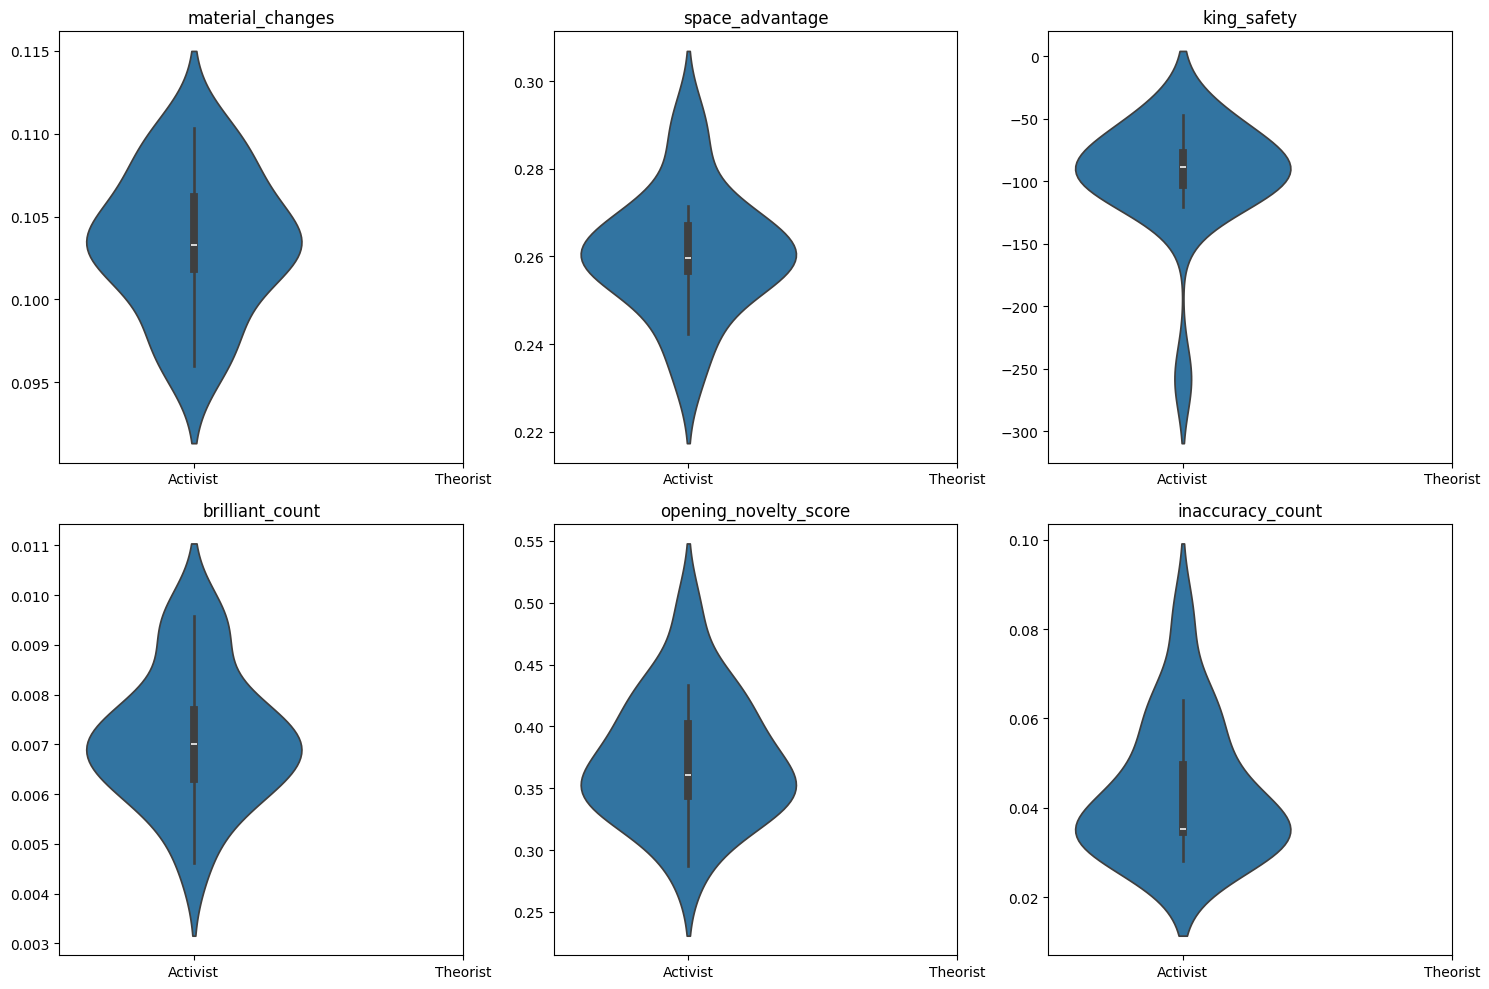


Step 3: Training classification models...

Model comparison:
  Random Forest: AUC = 0.7167 (±0.1633)
  Gradient Boosting: AUC = 0.4917 (±0.2115)
  Logistic Regression: AUC = 0.8167 (±0.1528)
  SVM: AUC = 0.8167 (±0.1528)
  KNN: AUC = 0.6417 (±0.1700)

Best model: Logistic Regression (AUC = 0.8167)

Logistic Regression Model Evaluation:
  Train Accuracy: 0.6667
  Test Accuracy: 0.5455
  Train AUC: 0.7917
  Test AUC: 0.5333

Classification Report:
              precision    recall  f1-score   support

    Theorist       0.60      0.50      0.55         6
    Activist       0.50      0.60      0.55         5

    accuracy                           0.55        11
   macro avg       0.55      0.55      0.55        11
weighted avg       0.55      0.55      0.55        11



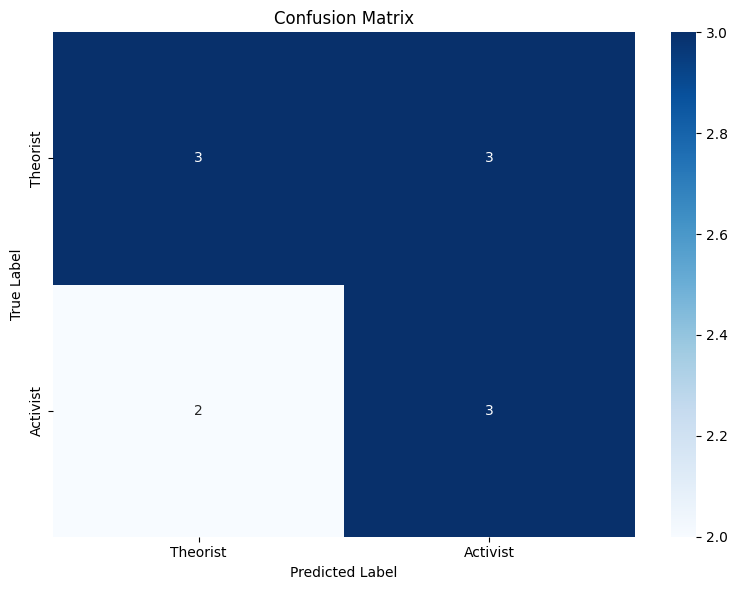


Step 4: Analyzing feature importance...


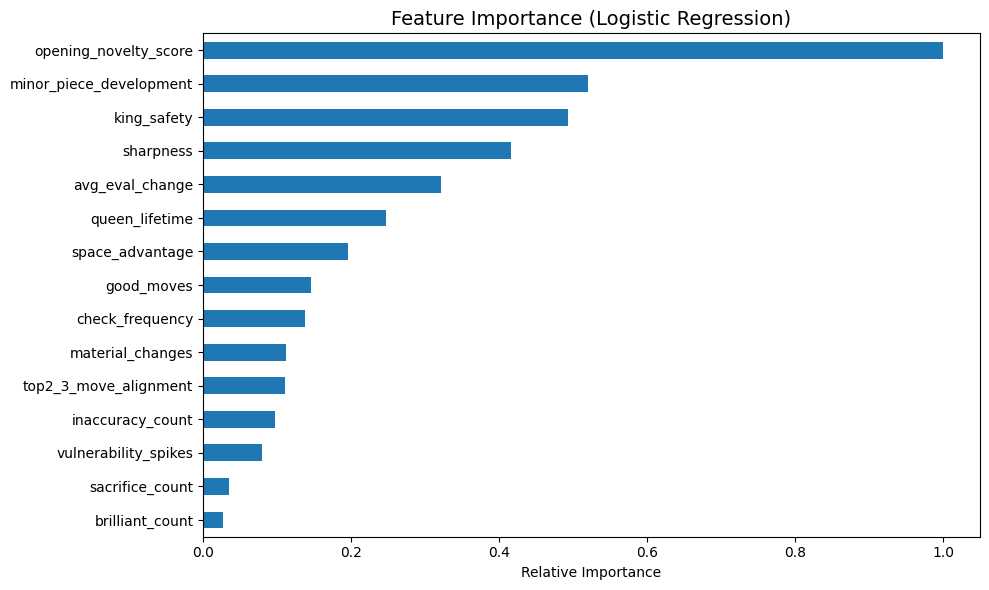


Feature comparison between Activist and Theorist players:
  sacrifice_count                Activist: 0.0151  Theorist: 0.0127  Diff: +17.43%
  brilliant_count                Activist: 0.0085  Theorist: 0.0071  Diff: +17.21%
  king_safety                    Activist: -113.0282  Theorist: -95.6535  Diff: +16.65%
  inaccuracy_count               Activist: 0.0503  Theorist: 0.0436  Diff: +14.18%
  avg_eval_change                Activist: 42.8754  Theorist: 37.5667  Diff: +13.20%
  opening_novelty_score          Activist: 0.4171  Theorist: 0.3741  Diff: +10.86%
  check_frequency                Activist: 0.0512  Theorist: 0.0477  Diff: +7.19%
  space_advantage                Activist: 0.2740  Theorist: 0.2611  Diff: +4.83%
  material_changes               Activist: 0.1076  Theorist: 0.1035  Diff: +3.89%
  sharpness                      Activist: 2.7561  Theorist: 2.6721  Diff: +3.09%
  top2_3_move_alignment          Activist: 0.2809  Theorist: 0.2897  Diff: -3.08%
  vulnerability_spikes    

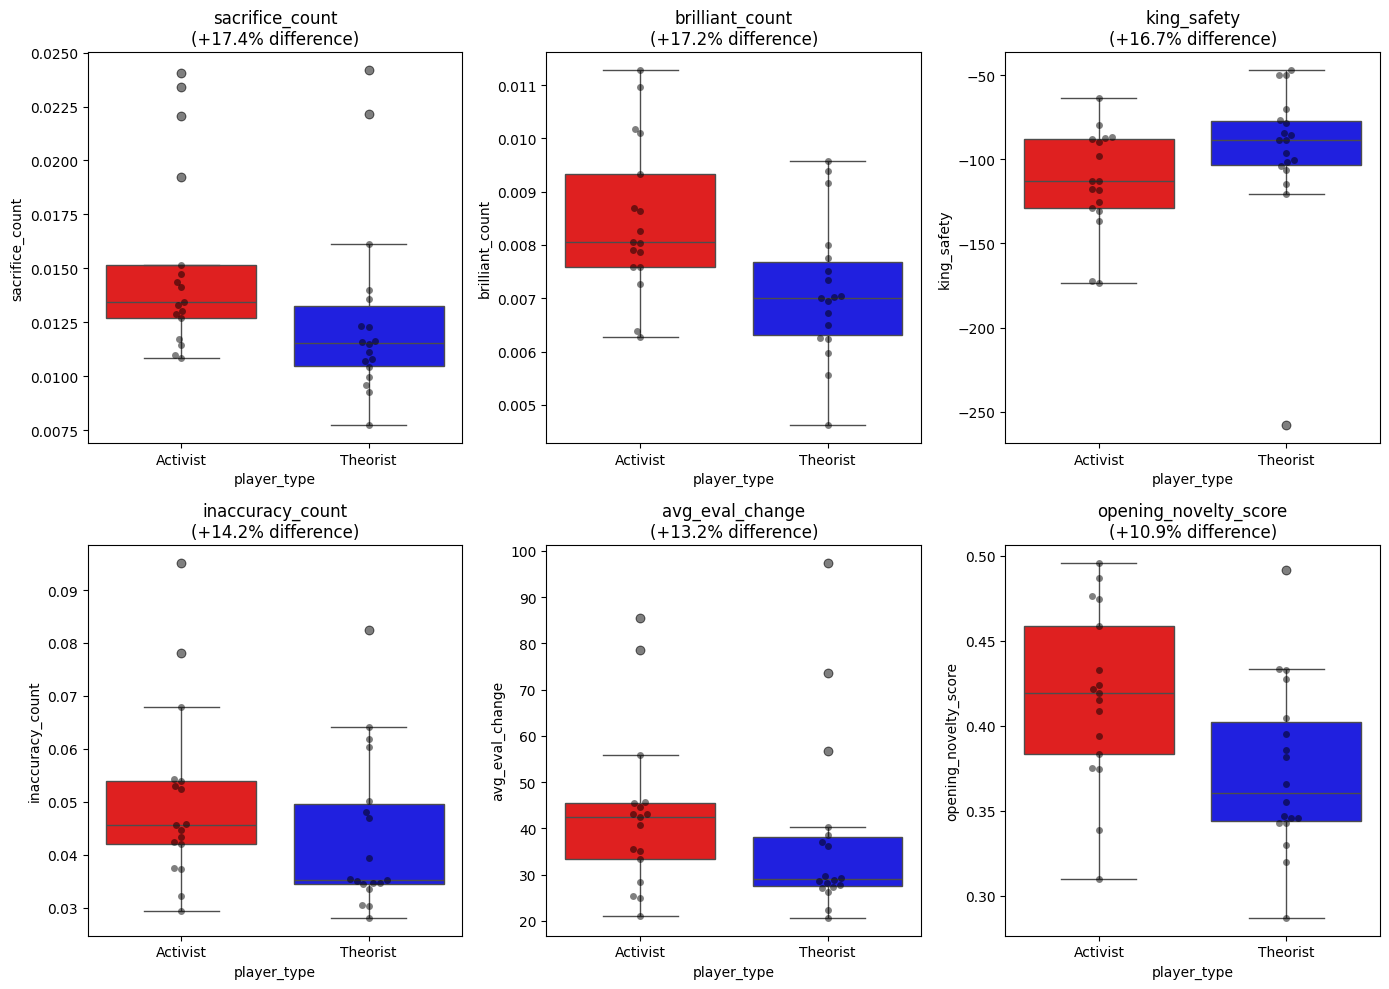


Step 5: Training specialized model for modern chess...

=== Training Modern Chess Player Model ===

Model evaluation for modern chess players:

Random Forest:
  Train Accuracy: 0.9167
  Test Accuracy: 0.8182
  Train AUC: 0.9931
  Test AUC: 0.8333

Gradient Boosting:
  Train Accuracy: 1.0000
  Test Accuracy: 0.6364
  Train AUC: 1.0000
  Test AUC: 0.6833

SVM:
  Train Accuracy: 0.7500
  Test Accuracy: 0.5455
  Train AUC: 0.2361
  Test AUC: 0.4000

Logistic Regression:
  Train Accuracy: 0.7500
  Test Accuracy: 0.5455
  Train AUC: 0.7778
  Test AUC: 0.5333

Best model for modern chess players: Random Forest (Test AUC: 0.8333)

Classification Report:
              precision    recall  f1-score   support

    Theorist       0.83      0.83      0.83         6
    Activist       0.80      0.80      0.80         5

    accuracy                           0.82        11
   macro avg       0.82      0.82      0.82        11
weighted avg       0.82      0.82      0.82        11



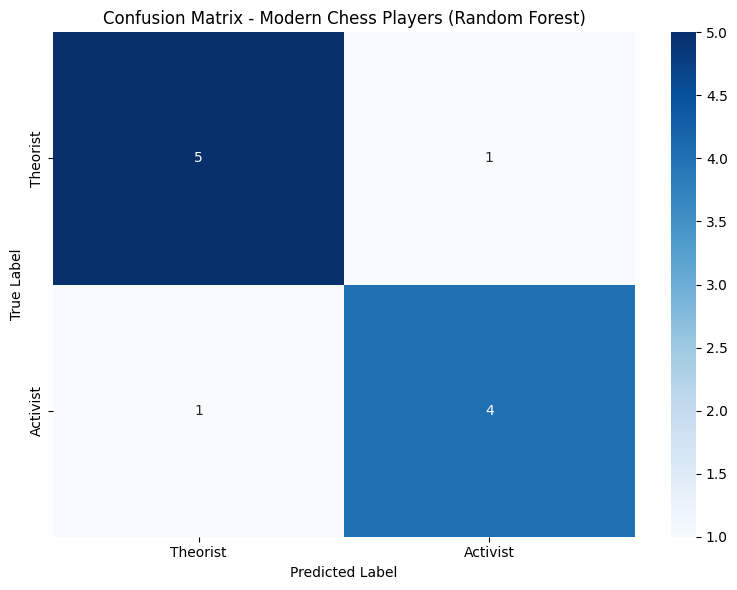


Comparison with standard model:
  Standard model accuracy: 0.5455
  Modern model accuracy: 0.5455
  Standard model AUC: 0.5333
  Modern model AUC: 0.8333

Step 6: Classifying unknown players...

Classifying 46 unknown players as Activist or Theorist
  Nakamura, Hikaru: classified as Activist with 0.85 confidence
  Svidler, Peter: classified as Theorist with 0.65 confidence
  Ivanchuk, Vasyl: classified as Activist with 0.69 confidence
  Gelfand, Boris: classified as Theorist with 0.67 confidence
  Grischuk, Alexander: classified as Theorist with 0.55 confidence
  So, Wesley: classified as Activist with 0.83 confidence
  Mamedyarov, Shakhriyar: classified as Activist with 0.59 confidence
  Radjabov, Teimour: classified as Activist with 0.54 confidence
  Nepomniachtchi, Ian: classified as Activist with 0.87 confidence
  Van Wely, Loek: classified as Activist with 0.97 confidence
  Bacrot, Etienne: classified as Theorist with 0.52 confidence
  Dominguez Perez, Leinier: classified as Acti

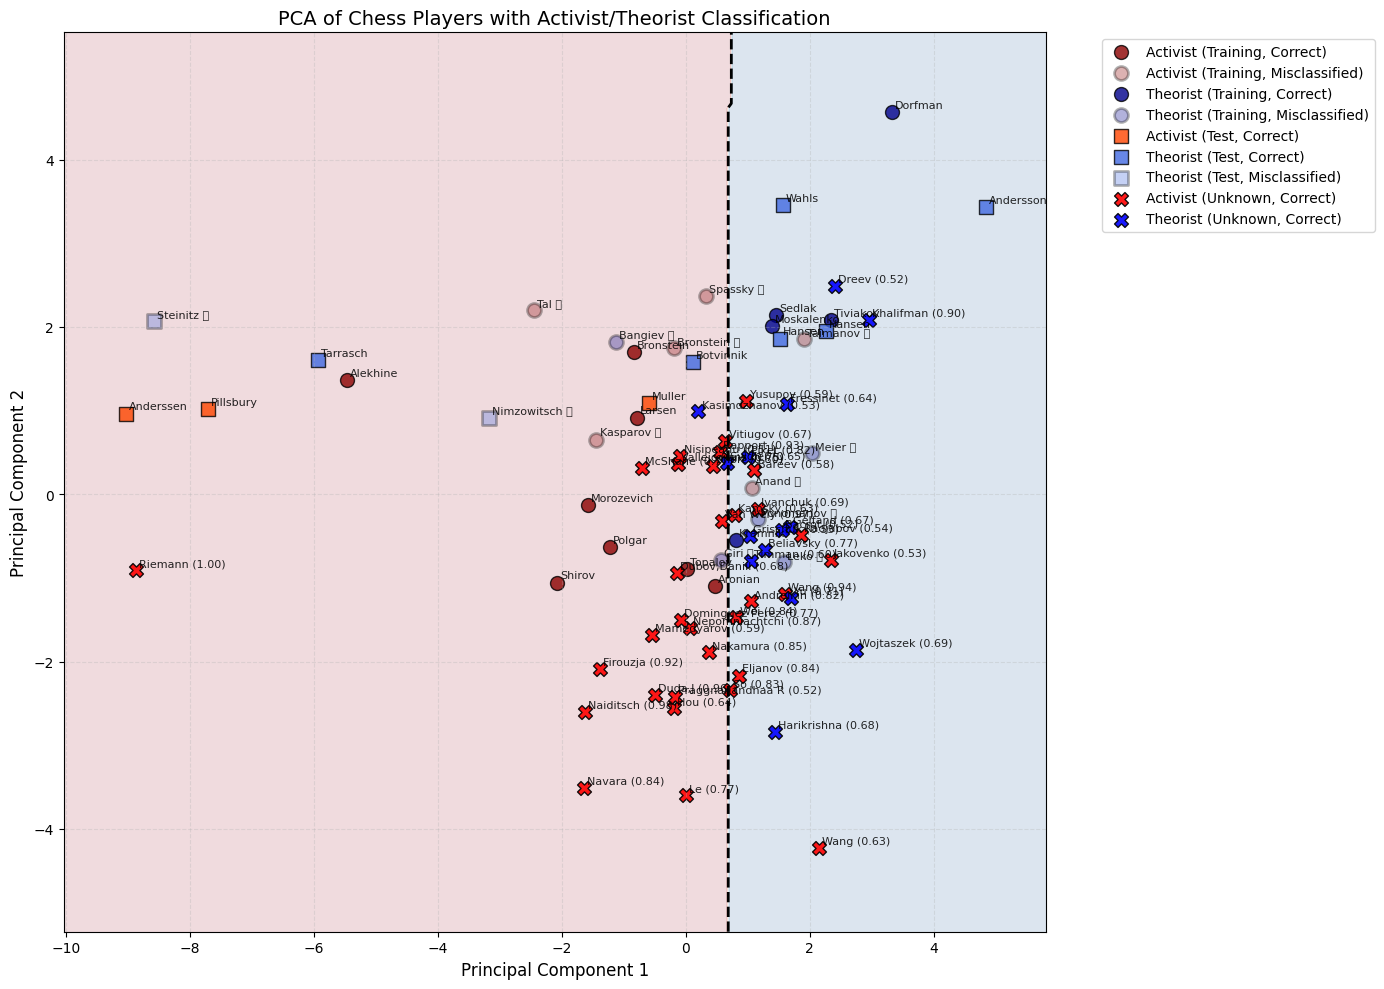

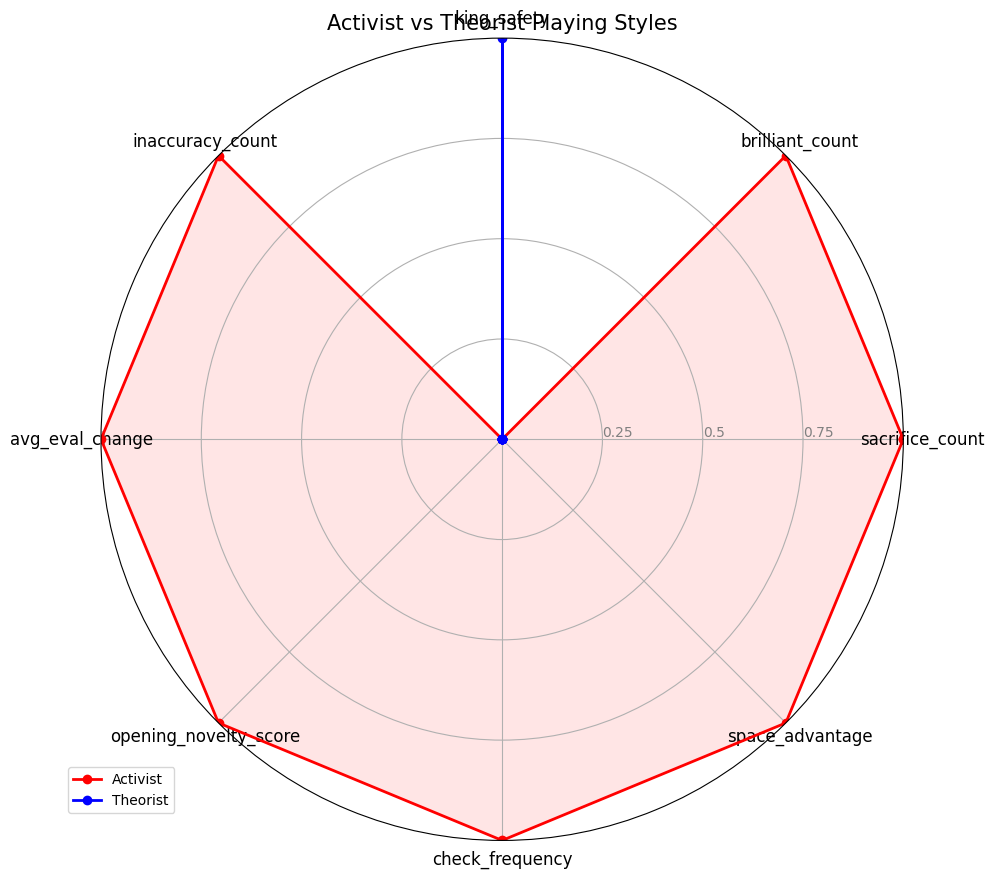


Results saved to 'classified_players.csv'

Classification pipeline complete!


In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.metrics import (
    roc_auc_score, classification_report, confusion_matrix, 
    accuracy_score, precision_score, recall_score, f1_score
)
from sklearn.feature_selection import mutual_info_classif
import warnings
warnings.filterwarnings('ignore')


# -----------------------------------------------------------------------------
# PART 1: DATA LOADING AND PREPROCESSING
# -----------------------------------------------------------------------------

class ChessPlayerData:
    """Class for loading and preprocessing chess player data."""
    
    # Define known player types
    KNOWN_PLAYERS = {
        'Activist': [
            "Kasparov", "Anand", "Shirov", "Morozevich",
            "Topalov", "Aronian", "Polgar", "Müller"
        ],
        'Theorist': [
            "Kramnik", "Leko", "Giri", "Meier", "Andersson",
            "Sedlak", "Tiviakov", "Ponomariov", "Wahls",
            "Moskalenko", "Dorfman", "Bangiev", "Hansen"
        ],
        'Reflector': [
            "Karpov", "Carlsen", "Adams, Michael", "Keymer", "Bischoff"
        ],
        'Pragmatist': [
            "Caruana", "Ding", "Karjakin", "Vachier-Lagrave"
        ]
    }
    
    def __init__(self, file_path='player_centric_data.csv', min_games=100):
        """
        Initialize and load chess player data.
        
        Args:
            file_path (str): Path to the CSV file with chess player data
            min_games (int): Minimum number of games required for a player to be included
        """
        self.file_path = file_path
        self.min_games = min_games
        self.raw_data = None
        self.player_data = None
        self.at_data = None  # Activist/Theorist only data
        self.features = None
        
    def load_data(self):
        """Load raw game-level data from CSV."""
        self.raw_data = pd.read_csv(self.file_path)
        print(f"Loaded {len(self.raw_data)} rows with {len(self.raw_data.columns)} columns.")
        return self.raw_data
    
    def aggregate_to_player_level(self):
        """Aggregate game-level data to player-level statistics."""
        if self.raw_data is None:
            self.load_data()
        
        # Identify players with enough games
        game_counts = self.raw_data['player_name'].value_counts()
        players_with_enough_games = game_counts[game_counts >= self.min_games].index.tolist()
        print(f"Found {len(players_with_enough_games)} players with at least {self.min_games} games.")

        # Filter to these players
        filtered_df = self.raw_data[self.raw_data['player_name'].isin(players_with_enough_games)].copy()

        # Columns that we will ignore for numeric aggregation
        ignore_cols = ['player_name', 'player_color', 'opponent_name', 'game_id', 'result', 'player_type']
        numeric_cols = [col for col in filtered_df.columns
                        if col not in ignore_cols and pd.api.types.is_numeric_dtype(filtered_df[col])]

        # Handle missing values in numeric columns
        filtered_df[numeric_cols] = filtered_df.groupby('player_name')[numeric_cols].transform(
            lambda x: x.fillna(x.mean()))

        aggregated_data = []

        for player in players_with_enough_games:
            player_games = filtered_df[filtered_df['player_name'] == player]
            # Get the first non-NaN player_type if available, default to 'Unknown'
            if 'player_type' in player_games.columns:
                p_type_series = player_games['player_type'].dropna()
                p_type = p_type_series.iloc[0] if not p_type_series.empty else 'Unknown'
            else:
                p_type = 'Unknown'

            player_stats = {
                'player_name': player,
                'player_type': p_type,
                'num_games': len(player_games)
            }
            # Compute averages for each numeric feature
            for col in numeric_cols:
                player_stats[col] = player_games[col].mean()
            aggregated_data.append(player_stats)

        self.player_data = pd.DataFrame(aggregated_data)
        return self.player_data
    
    def categorize_known_players(self):
        """Assign player types based on known lists of players."""
        if self.player_data is None:
            self.aggregate_to_player_level()
        
        # For tracking assignment stats
        assigned_type_count = 0
        
        # Categorize players by type
        for idx, player in self.player_data.iterrows():
            player_name = player['player_name']
            original_type = player['player_type']
            
            # Check each player type category
            for player_type, name_list in self.KNOWN_PLAYERS.items():
                if any(name in player_name for name in name_list):
                    self.player_data.at[idx, 'player_type'] = player_type
                    if original_type == 'Unknown':
                        assigned_type_count += 1
                    break
        
        # Summary of the categorization
        print(f"\nAssigned player types for {assigned_type_count} players from provided lists")
        
        # Count player types
        print(f"\nPlayer Types:")
        type_counts = self.player_data['player_type'].value_counts()
        for player_type, count in type_counts.items():
            print(f"  {player_type}: {count} players")
        
        return self.player_data
    
    def get_activist_theorist_data(self):
        """Create a DataFrame with only Activist and Theorist players for binary classification."""
        if self.player_data is None:
            self.categorize_known_players()
            
        self.at_data = self.player_data[self.player_data['player_type'].isin(['Activist', 'Theorist'])].copy()
        print(f"\nExtracted {len(self.at_data)} Activist/Theorist players for classification")
        return self.at_data


# -----------------------------------------------------------------------------
# PART 2: FEATURE SELECTION AND ENGINEERING
# -----------------------------------------------------------------------------

class FeatureSelector:
    """Class for selecting and analyzing features for chess player classification."""
    
    def __init__(self, data, n_features=15):
        """
        Initialize with player data.
        
        Args:
            data (pandas.DataFrame): Player-level data
            n_features (int): Number of top features to select
        """
        self.data = data
        self.n_features = n_features
        self.features = None
        self.X = None
        self.y = None
        
    def prepare_features(self):
        """Prepare feature matrix and target vector."""
        # Define features (excluding metadata)
        metadata = ['player_name', 'player_type', 'num_games']
        all_features = [col for col in self.data.columns 
                      if col not in metadata and pd.api.types.is_numeric_dtype(self.data[col])]
        
        # Prepare data
        self.X = self.data[all_features].copy()
        self.y = self.data['player_type'].map({'Activist': 1, 'Theorist': 0})
        
        # Handle missing values
        self.X = self.X.fillna(self.X.mean())
        
        return self.X, self.y
    
    def select_best_features(self):
        """Select best features using Random Forest and Mutual Information."""
        if self.X is None or self.y is None:
            self.prepare_features()
            
        # Calculate feature importance with Random Forest
        rf = RandomForestClassifier(n_estimators=1000, random_state=42)
        rf.fit(self.X, self.y)
        
        # Get and normalize importances
        rf_importances = pd.Series(rf.feature_importances_, index=self.X.columns)
        rf_importances = rf_importances / rf_importances.max()
        
        # Print top features
        print("\nTop features for distinguishing Activist vs Theorist (Random Forest):")
        for feature, importance in rf_importances.sort_values(ascending=False).head(self.n_features).items():
            print(f"  {feature}: {importance:.4f}")
        
        # Calculate mutual information scores as alternative measure
        mi_scores = mutual_info_classif(self.X, self.y, random_state=42)
        mi_importances = pd.Series(mi_scores, index=self.X.columns)
        mi_importances = mi_importances / mi_importances.max()
        
        print("\nTop features by mutual information:")
        for feature, importance in mi_importances.sort_values(ascending=False).head(self.n_features).items():
            print(f"  {feature}: {importance:.4f}")
        
        # Combine both methods for robust feature selection
        combined_importance = (rf_importances + mi_importances) / 2
        self.features = combined_importance.sort_values(ascending=False).head(self.n_features).index.tolist()
        
        print("\nSelected features (combined method):", self.features)
        
        return self.features
    
    def visualize_feature_distributions(self):
        """Visualize distributions of top features between player types."""
        if self.features is None:
            self.select_best_features()
            
        plt.figure(figsize=(15, 10))
        for i, feature in enumerate(self.features[:6]):  # Show top 6 features
            plt.subplot(2, 3, i+1)
            
            # Get data for each type
            activist_values = self.data[self.data['player_type'] == 'Activist'][feature]
            theorist_values = self.data[self.data['player_type'] == 'Theorist'][feature]
            
            # Create violin plots
            sns.violinplot(data=[activist_values, theorist_values])
            plt.xticks([0, 1], ['Activist', 'Theorist'])
            plt.title(feature)
        
        plt.tight_layout()
        plt.savefig('activist_vs_theorist_features.png', dpi=300)
        plt.show()
        
        return self.features


# -----------------------------------------------------------------------------
# PART 3: MODEL TRAINING AND EVALUATION
# -----------------------------------------------------------------------------

class ChessPlayerClassifier:
    """Class for training and evaluating chess player classification models."""
    
    def __init__(self, X, y, features, test_size=0.3, random_state=42):
        """
        Initialize with data and features.
        
        Args:
            X (pandas.DataFrame): Feature matrix
            y (pandas.Series): Target vector
            features (list): Selected feature names
            test_size (float): Proportion of data to use for testing
            random_state (int): Random seed for reproducibility
        """
        self.X = X[features].copy()
        self.y = y.copy()
        self.features = features
        self.test_size = test_size
        self.random_state = random_state
        self.best_model = None
        self.best_model_name = None
        self.X_train = None
        self.X_test = None
        self.y_train = None
        self.y_test = None
        
    def prepare_train_test_data(self):
        """Split data into training and test sets."""
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(
            self.X, self.y, test_size=self.test_size, random_state=self.random_state, stratify=self.y
        )
        return self.X_train, self.X_test, self.y_train, self.y_test
    
    def compare_models(self):
        """Compare multiple classification models."""
        if self.X_train is None:
            self.prepare_train_test_data()
            
        # Define models to compare
        models = {
            'Random Forest': RandomForestClassifier(n_estimators=1000, random_state=self.random_state),
            'Gradient Boosting': GradientBoostingClassifier(random_state=self.random_state),
            'Logistic Regression': LogisticRegression(max_iter=2000, random_state=self.random_state),
            'SVM': SVC(probability=True, random_state=self.random_state),
            'KNN': KNeighborsClassifier(n_neighbors=3)
        }
        
        # Define cross-validation strategy
        cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=self.random_state)
        
        # Results storage
        results = {}
        
        print("\nModel comparison:")
        for name, model in models.items():
            # Cross-validation scores
            scores = cross_val_score(model, self.X_train, self.y_train, cv=cv, scoring='roc_auc')
            mean_score = scores.mean()
            std_score = scores.std()
            results[name] = {'auc': mean_score, 'std': std_score}
            
            print(f"  {name}: AUC = {mean_score:.4f} (±{std_score:.4f})")
        
        # Find best model
        self.best_model_name = max(results, key=lambda x: results[x]['auc'])
        self.best_model = models[self.best_model_name]
        
        print(f"\nBest model: {self.best_model_name} (AUC = {results[self.best_model_name]['auc']:.4f})")
        
        return self.best_model, results
    
    def train_evaluate_model(self):
        """Train and evaluate the best model."""
        if self.best_model is None:
            self.compare_models()
            
        # Train the model on the full training set
        self.best_model.fit(self.X_train, self.y_train)
        
        # Evaluate on training and test data
        train_preds = self.best_model.predict(self.X_train)
        test_preds = self.best_model.predict(self.X_test)
        
        train_proba = self.best_model.predict_proba(self.X_train)[:, 1]
        test_proba = self.best_model.predict_proba(self.X_test)[:, 1]
        
        # Calculate metrics
        metrics = {
            'train_accuracy': accuracy_score(self.y_train, train_preds),
            'test_accuracy': accuracy_score(self.y_test, test_preds),
            'train_precision': precision_score(self.y_train, train_preds),
            'test_precision': precision_score(self.y_test, test_preds),
            'train_recall': recall_score(self.y_train, train_preds),
            'test_recall': recall_score(self.y_test, test_preds),
            'train_f1': f1_score(self.y_train, train_preds),
            'test_f1': f1_score(self.y_test, test_preds),
            'train_auc': roc_auc_score(self.y_train, train_proba),
            'test_auc': roc_auc_score(self.y_test, test_proba)
        }
        
        # Print evaluation results
        print(f"\n{self.best_model_name} Model Evaluation:")
        print(f"  Train Accuracy: {metrics['train_accuracy']:.4f}")
        print(f"  Test Accuracy: {metrics['test_accuracy']:.4f}")
        print(f"  Train AUC: {metrics['train_auc']:.4f}")
        print(f"  Test AUC: {metrics['test_auc']:.4f}")
        
        # Classification report
        print("\nClassification Report:")
        print(classification_report(self.y_test, test_preds, target_names=['Theorist', 'Activist']))
        
        # Confusion matrix
        cm = confusion_matrix(self.y_test, test_preds)
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                   xticklabels=['Theorist', 'Activist'],
                   yticklabels=['Theorist', 'Activist'])
        plt.title('Confusion Matrix')
        plt.ylabel('True Label')
        plt.xlabel('Predicted Label')
        plt.tight_layout()
        plt.savefig('confusion_matrix.png', dpi=300)
        plt.show()
        
        return self.best_model, metrics
    
    def train_modern_chess_model(self):
        """Train a specialized model for modern chess players."""
        if self.X_train is None:
            self.prepare_train_test_data()
            
        print("\n=== Training Modern Chess Player Model ===")
        
        # Define models with specialized parameters for modern chess
        models = {
            'Random Forest': RandomForestClassifier(
                n_estimators=1000, 
                max_depth=None,
                min_samples_split=5,
                min_samples_leaf=2,
                random_state=self.random_state
            ),
            'Gradient Boosting': GradientBoostingClassifier(
                n_estimators=200,
                learning_rate=0.1,
                max_depth=5,
                random_state=self.random_state
            ),
            'SVM': SVC(
                C=1.0,
                kernel='rbf',
                probability=True,
                random_state=self.random_state
            ),
            'Logistic Regression': LogisticRegression(
                C=1.0,
                penalty='l2',
                solver='liblinear',
                max_iter=1000,
                random_state=self.random_state
            )
        }
        
        best_auc = 0
        best_model = None
        best_model_name = None
        
        # Evaluate each model
        print("\nModel evaluation for modern chess players:")
        for name, model in models.items():
            # Train the model
            model.fit(self.X_train, self.y_train)
            
            # Get predictions
            y_train_pred = model.predict(self.X_train)
            y_test_pred = model.predict(self.X_test)
            
            # Calculate metrics
            train_accuracy = accuracy_score(self.y_train, y_train_pred)
            test_accuracy = accuracy_score(self.y_test, y_test_pred)
            
            train_auc = roc_auc_score(self.y_train, model.predict_proba(self.X_train)[:,1])
            test_auc = roc_auc_score(self.y_test, model.predict_proba(self.X_test)[:,1])
            
            # Print results
            print(f"\n{name}:")
            print(f"  Train Accuracy: {train_accuracy:.4f}")
            print(f"  Test Accuracy: {test_accuracy:.4f}")
            print(f"  Train AUC: {train_auc:.4f}")
            print(f"  Test AUC: {test_auc:.4f}")
            
            # Update best model if this one is better
            if test_auc > best_auc:
                best_auc = test_auc
                best_model = model
                best_model_name = name
        
        print(f"\nBest model for modern chess players: {best_model_name} (Test AUC: {best_auc:.4f})")
        
        # Get classification report for the best model
        y_pred = best_model.predict(self.X_test)
        print("\nClassification Report:")
        print(classification_report(self.y_test, y_pred, target_names=['Theorist', 'Activist']))
        
        # Confusion matrix for the best model
        cm = confusion_matrix(self.y_test, y_pred)
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                   xticklabels=['Theorist', 'Activist'],
                   yticklabels=['Theorist', 'Activist'])
        plt.title(f'Confusion Matrix - Modern Chess Players ({best_model_name})')
        plt.ylabel('True Label')
        plt.xlabel('Predicted Label')
        plt.tight_layout()
        plt.savefig('confusion_matrix_modern_chess.png', dpi=300)
        plt.show()
        
        # Compare with standard model
        if self.best_model is not None:
            std_preds = self.best_model.predict(self.X_test)
            std_accuracy = accuracy_score(self.y_test, std_preds)
            std_auc = roc_auc_score(self.y_test, self.best_model.predict_proba(self.X_test)[:,1])
            
            print("\nComparison with standard model:")
            print(f"  Standard model accuracy: {std_accuracy:.4f}")
            print(f"  Modern model accuracy: {test_accuracy:.4f}")
            print(f"  Standard model AUC: {std_auc:.4f}")
            print(f"  Modern model AUC: {best_auc:.4f}")
        
        return best_model
    
    def analyze_feature_importance(self):
        """Analyze feature importance for the best model."""
        if self.best_model is None:
            self.train_evaluate_model()
            
        # Get feature importances if possible
        if hasattr(self.best_model, 'feature_importances_'):
            # For tree-based models
            importances = pd.Series(self.best_model.feature_importances_, index=self.features)
        elif hasattr(self.best_model, 'coef_'):
            # For linear models like logistic regression
            importances = pd.Series(np.abs(self.best_model.coef_[0]), index=self.features)
        else:
            # For models without direct feature importance
            print("Model doesn't provide feature importances directly.")
            return None
            
        # Normalize and display feature importances
        importances = importances / importances.max()
        
        plt.figure(figsize=(10, 6))
        importances.sort_values().plot(kind='barh')
        plt.title(f'Feature Importance ({self.best_model_name})', fontsize=14)
        plt.xlabel('Relative Importance')
        plt.tight_layout()
        plt.savefig('feature_importance.png', dpi=300)
        plt.show()
        
        # Compare feature distributions between Activist and Theorist
        data = self.X.copy()
        data['player_type'] = self.y.map({1: 'Activist', 0: 'Theorist'})
        
        activist_means = data[data['player_type'] == 'Activist'][self.features].mean()
        theorist_means = data[data['player_type'] == 'Theorist'][self.features].mean()
        
        # Calculate percent difference
        percent_diff = (activist_means - theorist_means) / ((activist_means + theorist_means) / 2) * 100
        
        # Sort by absolute difference
        comparison = pd.DataFrame({
            'Activist Mean': activist_means,
            'Theorist Mean': theorist_means,
            'Percent Difference': percent_diff
        })
        comparison = comparison.sort_values('Percent Difference', key=abs, ascending=False)
        
        print("\nFeature comparison between Activist and Theorist players:")
        for feature, row in comparison.iterrows():
            diff_str = f"{row['Percent Difference']:+.2f}%"
            print(f"  {feature:30} Activist: {row['Activist Mean']:.4f}  Theorist: {row['Theorist Mean']:.4f}  Diff: {diff_str}")
        
        # Visualize the top differentiating features
        plt.figure(figsize=(14, 10))
        
        # Plot top 6 most differentiating features
        for i, feature in enumerate(comparison.index[:6]):
            plt.subplot(2, 3, i+1)
            
            # Create box plots with individual points overlaid
            sns.boxplot(x='player_type', y=feature, data=data, 
                        order=['Activist', 'Theorist'], palette=['red', 'blue'])
            
            # Add a swarm plot to show individual data points
            sns.swarmplot(x='player_type', y=feature, data=data,
                         order=['Activist', 'Theorist'], color='black', alpha=0.5)
            
            # Add title showing the percent difference
            diff = comparison.loc[feature, 'Percent Difference']
            plt.title(f"{feature}\n({diff:+.1f}% difference)")
            
        plt.tight_layout()
        plt.savefig('activist_theorist_feature_comparison.png', dpi=300)
        plt.show()
        
        return comparison


# -----------------------------------------------------------------------------
# PART 4: PLAYER CLASSIFICATION AND VISUALIZATION
# -----------------------------------------------------------------------------

class PlayerClassifier:
    """Class for classifying unknown players and visualizing results."""
    
    def __init__(self, player_data, model, features):
        """
        Initialize with player data and trained model.
        
        Args:
            player_data (pandas.DataFrame): Full player data
            model (sklearn estimator): Trained classification model
            features (list): Feature names used by the model
        """
        self.player_data = player_data.copy()
        self.model = model
        self.features = features
        self.classified_data = None
    
    def classify_unknown_players(self):
        """Classify players with unknown types as Activist or Theorist."""
        # Add classification columns to full dataset
        self.classified_data = self.player_data.copy()
        self.classified_data['prediction_confidence'] = 0.0
        self.classified_data['is_guessed'] = False
        
        # Filter to unknown players (excluding known Reflectors and Pragmatists)
        unknown_df = self.classified_data[self.classified_data['player_type'] == 'Unknown'].copy()
        
        if unknown_df.empty:
            print("No unknown players to classify.")
            return self.classified_data
        
        print(f"\nClassifying {len(unknown_df)} unknown players as Activist or Theorist")
        
        # Prepare features for prediction
        X_unknown = unknown_df[self.features].fillna(unknown_df[self.features].mean())
        
        # Get predictions
        proba = self.model.predict_proba(X_unknown)
        predictions = self.model.predict(X_unknown)
        
        # Convert to player types
        player_types = ['Theorist', 'Activist']
        predicted_types = [player_types[p] for p in predictions]
        
        # Get confidence (probability of the predicted class)
        confidence = [max(p) for p in proba]
        
        # Update results DataFrame
        for i, idx in enumerate(unknown_df.index):
            self.classified_data.at[idx, 'player_type'] = predicted_types[i]
            self.classified_data.at[idx, 'prediction_confidence'] = confidence[i]
            self.classified_data.at[idx, 'is_guessed'] = True
            
            # Print prediction
            player_name = unknown_df.iloc[i]['player_name']
            print(f"  {player_name}: classified as {predicted_types[i]} with {confidence[i]:.2f} confidence")
        
        # Also get model predictions for ALL known players to evaluate accuracy
        known_df = self.classified_data[~self.classified_data['is_guessed'] & 
                                      self.classified_data['player_type'].isin(['Activist', 'Theorist'])].copy()
        
        if not known_df.empty:
            print("\nVerifying model predictions on known players...")
            
            # Prepare features
            X_known = known_df[self.features].fillna(known_df[self.features].mean())
            
            # Get predictions
            known_proba = self.model.predict_proba(X_known)
            known_predictions = self.model.predict(X_known)
            
            # Convert to player types
            known_predicted_types = [player_types[p] for p in known_predictions]
            
            # Get confidence
            known_confidence = [max(p) for p in known_proba]
            
            # Count correct predictions
            correct_count = 0
            for i, idx in enumerate(known_df.index):
                true_type = known_df.iloc[i]['player_type']
                predicted_type = known_predicted_types[i]
                confidence_val = known_confidence[i]
                
                # Update confidence in results DataFrame
                self.classified_data.at[idx, 'prediction_confidence'] = confidence_val
                
                if true_type == predicted_type:
                    correct_count += 1
                else:
                    player_name = known_df.iloc[i]['player_name']
                    print(f"  Misclassification: {player_name} is {true_type} but predicted as {predicted_type} with {confidence_val:.2f} confidence")
            
            accuracy = correct_count / len(known_df) * 100
            print(f"  Model accuracy on known players: {accuracy:.2f}% ({correct_count}/{len(known_df)})")
        
        # Count players by type after classification
        print("\nPlayer type distribution after classification:")
        for player_type in self.classified_data['player_type'].unique():
            count = len(self.classified_data[self.classified_data['player_type'] == player_type])
            print(f"  {player_type}: {count} players")
        
        return self.classified_data
    
    def visualize_pca_classification(self):
        """Create PCA visualization of player types with training/test split."""
        if self.classified_data is None:
            self.classify_unknown_players()
            
        # Filter to just Activist and Theorist players
        at_df = self.classified_data[self.classified_data['player_type'].isin(['Activist', 'Theorist'])].copy()
        
        # Extract features
        X = at_df[self.features].fillna(at_df[self.features].mean())
        
        # Impute and scale data
        imputer = SimpleImputer(strategy='mean')
        scaler = StandardScaler()
        X_imputed = imputer.fit_transform(X)
        X_scaled = scaler.fit_transform(X_imputed)
        
        # Apply PCA
        pca = PCA(n_components=2, random_state=42)
        X_pca = pca.fit_transform(X_scaled)
        
        # Create DataFrame for visualization
        pca_df = pd.DataFrame({
            'PC1': X_pca[:, 0],
            'PC2': X_pca[:, 1],
            'player_type': at_df['player_type'],
            'player_name': at_df['player_name'],
            'is_guessed': at_df['is_guessed'],
            'confidence': at_df['prediction_confidence']
        })
        
        # Get model predictions on PCA data
        if self.model is not None:
            # Get predictions for all players
            X_features = at_df[self.features].fillna(at_df[self.features].mean())
            predictions = self.model.predict(X_features)
            true_labels = at_df['player_type'].map({'Activist': 1, 'Theorist': 0}).values
            
            # Add prediction info to dataframe
            pca_df['model_prediction'] = ['Activist' if p == 1 else 'Theorist' for p in predictions]
            pca_df['correctly_classified'] = predictions == true_labels
        else:
            # If no model, assume all are correctly classified
            pca_df['correctly_classified'] = True
            pca_df['model_prediction'] = pca_df['player_type']
        
        # Split known players into training/test groups (70/30)
        known_idx = pca_df[~pca_df['is_guessed']].index
        training_idx = known_idx[:int(len(known_idx) * 0.7)]
        test_idx = known_idx[int(len(known_idx) * 0.7):]
        unknown_idx = pca_df[pca_df['is_guessed']].index
        
        pca_df['data_group'] = 'unknown'  # default
        pca_df.loc[training_idx, 'data_group'] = 'training'
        pca_df.loc[test_idx, 'data_group'] = 'test'
        
        # Create plot
        plt.figure(figsize=(14, 10))
        
        # Create decision boundary
        if self.model is not None:
            # Create a mesh grid
            h = 0.05  # Step size
            x_min, x_max = pca_df['PC1'].min() - 1, pca_df['PC1'].max() + 1
            y_min, y_max = pca_df['PC2'].min() - 1, pca_df['PC2'].max() + 1
            xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
            
            # Fit a simple logistic regression model for visualization
            boundary_model = LogisticRegression(random_state=42)
            boundary_model.fit(
                pca_df.loc[training_idx, ['PC1', 'PC2']], 
                pca_df.loc[training_idx, 'player_type'].map({'Activist': 1, 'Theorist': 0})
            )
            
            # Predict on the mesh grid
            Z = boundary_model.predict(np.c_[xx.ravel(), yy.ravel()])
            Z = Z.reshape(xx.shape)
            
            # Plot the decision boundary
            plt.contourf(xx, yy, Z, alpha=0.15, cmap=plt.cm.RdBu_r)
            plt.contour(xx, yy, Z, [0.5], linewidths=2, colors='k', linestyles='--')
        
        # Define marker and color mappings
        colors = {
            ('training', 'Activist'): 'darkred',
            ('training', 'Theorist'): 'darkblue',
            ('test', 'Activist'): 'orangered',
            ('test', 'Theorist'): 'royalblue',
            ('unknown', 'Activist'): 'red',
            ('unknown', 'Theorist'): 'blue'
        }
        
        markers = {
            'training': 'o',  # circle for training
            'test': 's',      # square for test
            'unknown': 'X'    # X for unknown
        }
        
        # Plot each group
        for data_group in ['training', 'test', 'unknown']:
            for player_type in ['Activist', 'Theorist']:
                # Correct classifications
                subset = pca_df[
                    (pca_df['data_group'] == data_group) & 
                    (pca_df['player_type'] == player_type) &
                    (pca_df['correctly_classified'] == True)
                ]
                
                if not subset.empty:
                    label = f"{player_type} ({data_group.capitalize()}, Correct)"
                    plt.scatter(
                        subset['PC1'], 
                        subset['PC2'], 
                        marker=markers[data_group], 
                        c=colors[(data_group, player_type)], 
                        s=100, 
                        alpha=0.8 if data_group != 'unknown' else 0.9,
                        label=label, 
                        edgecolor='black'
                    )
                
                # Incorrect classifications (only for known players)
                if data_group in ['training', 'test']:
                    subset = pca_df[
                        (pca_df['data_group'] == data_group) & 
                        (pca_df['player_type'] == player_type) &
                        (pca_df['correctly_classified'] == False)
                    ]
                    
                    if not subset.empty:
                        label = f"{player_type} ({data_group.capitalize()}, Misclassified)"
                        plt.scatter(
                            subset['PC1'], 
                            subset['PC2'], 
                            marker=markers[data_group], 
                            c=colors[(data_group, player_type)], 
                            s=100, 
                            alpha=0.3,  # lower alpha for misclassified
                            label=label, 
                            edgecolor='black',
                            linewidths=2
                        )
        
        # Add player name labels with confidence scores
        for _, row in pca_df.iterrows():
            # Format the label based on player name
            if ', ' in row['player_name']:
                label = row['player_name'].split(', ')[0]
            elif '(' in row['player_name']:
                label = row['player_name'].split('(')[0].strip()
            else:
                label = row['player_name']
            
            # Add confidence score for unknown players
            if row['is_guessed'] and row['confidence'] > 0:
                label = f"{label} ({row['confidence']:.2f})"
            
            # Add marker for incorrect classifications
            if not row['correctly_classified']:
                label = f"{label} ❌"
            
            plt.text(
                row['PC1'] + 0.05, 
                row['PC2'] + 0.05, 
                label, 
                fontsize=8,
                alpha=0.85
            )
        
        plt.title('PCA of Chess Players with Activist/Theorist Classification', fontsize=14)
        plt.xlabel('Principal Component 1', fontsize=12)
        plt.ylabel('Principal Component 2', fontsize=12)
        plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.grid(True, linestyle='--', alpha=0.3)
        plt.tight_layout()
        plt.savefig('activist_theorist_classification.png', dpi=300)
        plt.show()
        
        return pca_df
        
    def create_radar_chart(self, n_features=8):
        """Create a radar chart comparing Activist and Theorist player characteristics."""
        if self.classified_data is None:
            self.classify_unknown_players()
            
        # Filter to known Activist and Theorist players
        known_at = self.classified_data[
            (~self.classified_data['is_guessed']) & 
            (self.classified_data['player_type'].isin(['Activist', 'Theorist']))
        ].copy()
        
        # Calculate mean values for each type
        activist_means = known_at[known_at['player_type'] == 'Activist'][self.features].mean()
        theorist_means = known_at[known_at['player_type'] == 'Theorist'][self.features].mean()
        
        # Calculate percent difference
        percent_diff = (activist_means - theorist_means) / ((activist_means + theorist_means) / 2) * 100
        
        # Get top differentiating features
        comparison = pd.DataFrame({
            'Activist Mean': activist_means,
            'Theorist Mean': theorist_means,
            'Percent Difference': percent_diff
        })
        comparison = comparison.sort_values('Percent Difference', key=abs, ascending=False)
        
        # Take top N features by absolute difference
        top_features = comparison.index[:n_features].tolist()
        
        # Get data for these features
        activist_values = activist_means[top_features].values
        theorist_values = theorist_means[top_features].values
        
        # Normalize the values to 0-1 range for better visualization
        min_vals = np.minimum(activist_values, theorist_values)
        max_vals = np.maximum(activist_values, theorist_values)
        range_vals = max_vals - min_vals
        
        # Avoid division by zero
        range_vals[range_vals == 0] = 1
        
        activist_norm = (activist_values - min_vals) / range_vals
        theorist_norm = (theorist_values - min_vals) / range_vals
        
        # Set up the figure
        fig = plt.figure(figsize=(10, 10))
        ax = fig.add_subplot(111, polar=True)
        
        # Number of variables
        N = len(top_features)
        
        # What will be the angle of each axis in the plot
        angles = [n / float(N) * 2 * np.pi for n in range(N)]
        angles += angles[:1]  # Close the loop
        
        # Add the feature names as axis labels
        plt.xticks(angles[:-1], top_features, size=12)
        
        # Draw the chart
        ax.set_rlabel_position(0)
        plt.yticks([0.25, 0.5, 0.75], ["0.25","0.5","0.75"], color="grey", size=10)
        plt.ylim(0, 1)
        
        # Plot data
        activist_values = np.concatenate((activist_norm, [activist_norm[0]]))  # Close the loop
        theorist_values = np.concatenate((theorist_norm, [theorist_norm[0]]))  # Close the loop
        
        # Plot Activist
        ax.plot(angles, activist_values, 'o-', linewidth=2, color='red', label='Activist')
        ax.fill(angles, activist_values, 'red', alpha=0.1)
        
        # Plot Theorist
        ax.plot(angles, theorist_values, 'o-', linewidth=2, color='blue', label='Theorist')
        ax.fill(angles, theorist_values, 'blue', alpha=0.1)
        
        # Add legend
        plt.legend(loc='upper right', bbox_to_anchor=(0.1, 0.1))
        
        plt.title('Activist vs Theorist Playing Styles', size=15)
        plt.tight_layout()
        plt.savefig('activist_theorist_radar.png', dpi=300)
        plt.show()
        
        return comparison
    
    
# -----------------------------------------------------------------------------
# PART 5: MAIN EXECUTION
# -----------------------------------------------------------------------------

def main():
    """Execute the full chess player classification pipeline."""
    
    print("=" * 80)
    print("CHESS PLAYER STYLE CLASSIFICATION")
    print("=" * 80)
    
    # Step 1: Load and preprocess data
    print("\nStep 1: Loading and preprocessing data...")
    data_processor = ChessPlayerData(file_path='player_centric_data.csv', min_games=100)
    data_processor.load_data()
    data_processor.aggregate_to_player_level()
    player_data = data_processor.categorize_known_players()
    at_data = data_processor.get_activist_theorist_data()
    
    # Step 2: Select features
    print("\nStep 2: Selecting features...")
    feature_selector = FeatureSelector(at_data, n_features=15)
    selected_features = feature_selector.select_best_features()
    feature_selector.visualize_feature_distributions()
    
    # Step 3: Train and evaluate models
    print("\nStep 3: Training classification models...")
    X = at_data[selected_features].fillna(at_data[selected_features].mean())
    y = at_data['player_type'].map({'Activist': 1, 'Theorist': 0})
    
    classifier = ChessPlayerClassifier(X, y, selected_features)
    classifier.prepare_train_test_data()
    best_model, model_results = classifier.compare_models()
    classifier.train_evaluate_model()
    
    # Step 4: Analyze feature importance
    print("\nStep 4: Analyzing feature importance...")
    classifier.analyze_feature_importance()
    
    # Step 5: Train specialized model for modern chess
    print("\nStep 5: Training specialized model for modern chess...")
    modern_model = classifier.train_modern_chess_model()
    
    # Step 6: Classify unknown players
    print("\nStep 6: Classifying unknown players...")
    player_classifier = PlayerClassifier(player_data, best_model, selected_features)
    classified_data = player_classifier.classify_unknown_players()
    
    # Step 7: Visualize classification results
    print("\nStep 7: Creating visualizations...")
    player_classifier.visualize_pca_classification()
    player_classifier.create_radar_chart()
    
    # Step 8: Save results
    classified_data.to_csv('classified_players.csv', index=False)
    print("\nResults saved to 'classified_players.csv'")
    
    print("\nClassification pipeline complete!")


if __name__ == "__main__":
    main()

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import plotly.express as px
import plotly.graph_objects as go
from sklearn.cluster import KMeans
from sklearn.impute import SimpleImputer
from typing import List, Dict, Optional, Union, Tuple
import warnings
warnings.filterwarnings('ignore')

# Set the style for visualizations
plt.style.use('fivethirtyeight')
sns.set_palette("viridis")
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12

def load_chess_data(csv_file):
    """Load chess data from CSV file and perform basic preprocessing"""
    df = pd.read_csv(csv_file)
    print(f"Loaded {df.shape[0]} games with {df.shape[1]} features")
    
    # Define player types if 'player_type' column exists
    if 'player_type' in df.columns:
        # Map player names to types
        player_types = {
            'Activist': ['Alekhine', 'Tal', 'Spassky', 'Kasparov', 'Anand', 'Shirov', 'Topalov', ],
            'Theorist': ['Steinitz', 'Botvinnik', 'Kramnik', 'Tarrasch', 'Nimzowitsch', 'Leko', 'Giri'],
            'Reflector': ['Capablanca', 'Smyslov', 'Petrosian', 'Karpov', 'Carlsen', 'Adams'],
            'Pragmatist': ['Fischer', 'Euwe', 'Korchnoi', 'Caruana', 'Ding']
        }
        
        # Fill in missing player types based on player name
        for player_type, names in player_types.items():
            for name in names:
                mask = df['player_name'].str.contains(name, case=False, na=False)
                if any(mask):
                    df.loc[mask & df['player_type'].isna(), 'player_type'] = player_type
    
    # Define feature groups based on available columns
    feature_groups = get_feature_groups(df.columns)
    
    return df, feature_groups

def get_feature_groups(available_columns):
    """Define feature groups based on available columns"""
    # Convert available columns to a list if it's not already
    available_features = list(available_columns)
    
    # Define feature groups with only available features
    feature_groups = {
        'Opening Features': [f for f in [
            'minor_piece_development', 'queen_development', 'castle_move', 
            'opening_novelty_score', 'opening_accuracy', 'opening_length'
        ] if f in available_features],
        
        'Material Handling': [f for f in [
            'material_changes', 'material_volatility', 'piece_exchange_rate', 
            'pawn_exchange_rate', 'capture_frequency', 'material_balance_std'
        ] if f in available_features],
        
        'Positional Features': [f for f in [
            'piece_mobility_avg', 'pawn_structure_changes', 'pawn_control', 
            'center_control_avg', 'space_advantage'
        ] if f in available_features],
        
        'King Safety': [f for f in [
            'king_safety', 'king_safety_min', 'vulnerability_spikes', 'check_frequency'
        ] if f in available_features],
        
        'Move Quality': [f for f in [
            'accuracy', 'brilliant_count', 'great_count', 'good_moves', 
            'inaccuracy_count', 'mistake_count', 'blunder_count', 
            'top_move_alignment', 'top2_3_move_alignment'
        ] if f in available_features],
        
        'Game Phase': [f for f in [
            'middlegame_accuracy', 'endgame_accuracy', 'middlegame_length', 'endgame_length'
        ] if f in available_features],
        
        'Strategic Indicators': [f for f in [
            'sacrifice_count', 'prophylactic_frequency', 'sharpness', 
            'eval_volatility', 'avg_eval_change'
        ] if f in available_features],
        
        'Game Stats': [f for f in [
            'total_moves', 'opening_length', 'middlegame_length', 'endgame_length'
        ] if f in available_features]
    }
    
    # Remove empty groups
    feature_groups = {k: v for k, v in feature_groups.items() if v}
    
    return feature_groups

def get_selected_features(df, feature_selection):
    """Get selected features based on different input types"""
    # Define common feature groups
    feature_groups = get_feature_groups(df.columns)
    
    # Identify non-feature columns
    meta_cols = ['player_name', 'player_color', 'opponent_name', 'player_elo', 
                'player_type', 'game_id', 'result']
    
    # If feature_selection is a string, it might be a group name or a keyword
    if isinstance(feature_selection, str):
        if feature_selection in feature_groups:
            # It's a feature group name
            selected_features = feature_groups[feature_selection]
        else:
            # It's a keyword to search in feature names
            selected_features = [col for col in df.columns 
                               if col not in meta_cols 
                               and feature_selection.lower() in col.lower()]
    
    # If it's a list, use those features directly
    elif isinstance(feature_selection, list):
        selected_features = [f for f in feature_selection if f in df.columns]
    
    # If it's a list of group names, combine all groups
    elif isinstance(feature_selection, list) and all(g in feature_groups for g in feature_selection):
        selected_features = []
        for group in feature_selection:
            selected_features.extend(feature_groups[group])
    
    # Default to all numeric features if no selection or invalid selection
    else:
        selected_features = [col for col in df.columns 
                           if col not in meta_cols 
                           and pd.api.types.is_numeric_dtype(df[col])]
    
    return selected_features

def compare_player_games(df, player1, player2, feature_selection=None, top_n=10):
    """
    Compare games between two chess players across multiple features.
    
    Args:
        df: DataFrame with player data
        player1: Name of first player (partial name matching)
        player2: Name of second player (partial name matching)
        feature_selection: Features to analyze (string group name, list of features, or keyword)
        top_n: Number of top differences to display
        
    Returns:
        DataFrame with comparison results
    """
    # Select players' games
    player1_mask = df['player_name'].str.contains(player1, case=False, na=False)
    player2_mask = df['player_name'].str.contains(player2, case=False, na=False)
    
    player1_games = df[player1_mask].copy()
    player2_games = df[player2_mask].copy()
    
    print(f"Found {len(player1_games)} games for {player1}")
    print(f"Found {len(player2_games)} games for {player2}")
    
    if len(player1_games) < 5 or len(player2_games) < 5:
        print("Warning: Very few games found. Results may not be statistically reliable.")
    
    # Get selected features
    selected_features = get_selected_features(df, feature_selection)
    print(f"Analyzing {len(selected_features)} features")
    
    # Add a group column for easier comparison
    player1_games['player_group'] = f"Player: {player1}"
    player2_games['player_group'] = f"Player: {player2}"
    
    # Combine into one dataframe for analysis
    comparison_df = pd.concat([player1_games, player2_games])
    
    # Calculate statistics and significance for each feature
    results = []
    
    for feature in selected_features:
        # Skip if feature doesn't exist
        if feature not in df.columns:
            continue
            
        # Get data for both players
        data1 = player1_games[feature].dropna()
        data2 = player2_games[feature].dropna()
        
        # Skip if not enough data
        if len(data1) < 5 or len(data2) < 5:
            continue
            
        # Calculate statistics
        mean1 = data1.mean()
        mean2 = data2.mean()
        std1 = data1.std()
        std2 = data2.std()
        
        # T-test for significance
        t_stat, p_value = scipy.stats.ttest_ind(data1, data2, equal_var=False)
        
        # Calculate effect size (Cohen's d)
        pooled_std = np.sqrt(((len(data1) - 1) * std1**2 + (len(data2) - 1) * std2**2) / 
                           (len(data1) + len(data2) - 2))
        
        effect_size = abs(mean1 - mean2) / pooled_std if pooled_std > 0 else 0
        
        # Determine which player has higher value
        higher = player1 if mean1 > mean2 else player2
        
        # Calculate percent difference
        pct_diff = ((mean1 - mean2) / abs(mean2)) * 100 if mean2 != 0 else 0
        
        # Add to results
        results.append({
            'Feature': feature,
            'p_value': p_value,
            'effect_size': effect_size,
            player1: mean1,
            player2: mean2,
            'Percent_Diff': pct_diff,
            'Higher': higher
        })
    
    # Create results dataframe and sort by significance
    results_df = pd.DataFrame(results)
    
    if len(results_df) == 0:
        print("No valid features found for comparison.")
        return pd.DataFrame()
        
    results_df = results_df.sort_values('p_value')
    
    # Print top significant differences
    significant_results = results_df[results_df['p_value'] < 0.05]
    
    if len(significant_results) > 0:
        print("\nMost significant differences:")
        for _, row in significant_results.head(top_n).iterrows():
            stars = "***" if row['p_value'] < 0.001 else "**" if row['p_value'] < 0.01 else "*"
            effect = "large" if row['effect_size'] >= 0.8 else "medium" if row['effect_size'] >= 0.5 else "small"
            
            print(f"{row['Feature']}: {stars} (p={row['p_value']:.4f}, {effect} effect)")
            print(f"  {player1}: {row[player1]:.2f}, {player2}: {row[player2]:.2f}")
            print(f"  {row['Higher']} is higher by {abs(row['Percent_Diff']):.1f}%\n")
    else:
        print("No statistically significant differences found.")
        
    # Create visualizations only if we have significant results
    if len(significant_results) > 0:
        # 1. Bar chart of top differences
        plt.figure(figsize=(12, 8))
        
        top_features = significant_results['Feature'].head(min(8, len(significant_results))).tolist()
        
        if top_features:
            # Prepare data for plotting
            plot_data = []
            for feature in top_features:
                row = results_df[results_df['Feature'] == feature].iloc[0]
                plot_data.append({
                    'Feature': feature,
                    player1: row[player1],
                    player2: row[player2],
                    'p_value': row['p_value']
                })
            
            plot_df = pd.DataFrame(plot_data)
            
            # Convert to long format for seaborn
            plot_long = pd.melt(plot_df, 
                               id_vars=['Feature', 'p_value'], 
                               value_vars=[player1, player2],
                               var_name='Player', value_name='Value')
            
            # Create plot
            plt.figure(figsize=(14, 8))
            ax = sns.barplot(x='Feature', y='Value', hue='Player', data=plot_long)
            
            # Add significance stars
            for i, feature in enumerate(top_features):
                p_val = plot_df[plot_df['Feature'] == feature]['p_value'].iloc[0]
                stars = "***" if p_val < 0.001 else "**" if p_val < 0.01 else "*"
                plt.text(i, 0, stars, ha='center', va='bottom', fontsize=16)
                
            plt.xticks(rotation=45, ha='right')
            plt.title(f'Top Differences: {player1} vs {player2}')
            plt.tight_layout()
            plt.show()
        
            # 2. Radar chart
            # Get top 6 differentiating features
            radar_features = significant_results['Feature'].head(min(6, len(significant_results))).tolist()
            
            try:
                # Create radar chart for features
                fig = go.Figure()
                
                # Prepare normalized values for each player
                values1 = []
                values2 = []
                
                for feature in radar_features:
                    row = results_df[results_df['Feature'] == feature].iloc[0]
                    # Get the raw values
                    val1 = row[player1]
                    val2 = row[player2]
                    
                    # Simple normalization between 0 and 1
                    max_val = max(val1, val2)
                    min_val = min(val1, val2)
                    
                    # Prevent division by zero
                    if max_val == min_val:
                        norm1 = 0.5
                        norm2 = 0.5
                    else:
                        norm1 = (val1 - min_val) / (max_val - min_val)
                        norm2 = (val2 - min_val) / (max_val - min_val)
                    
                    values1.append(norm1)
                    values2.append(norm2)
                    
                # Close the loop for the radar chart
                values1.append(values1[0])
                values2.append(values2[0])
                radar_features_closed = radar_features + [radar_features[0]]
                
                # Add traces
                fig.add_trace(go.Scatterpolar(
                    r=values1,
                    theta=radar_features_closed,
                    fill='toself',
                    name=player1
                ))
                
                fig.add_trace(go.Scatterpolar(
                    r=values2,
                    theta=radar_features_closed,
                    fill='toself',
                    name=player2
                ))
                
                fig.update_layout(
                    polar=dict(
                        radialaxis=dict(
                            visible=True,
                            range=[0, 1]
                        )
                    ),
                    title=f"Playing Style Comparison: {player1} vs {player2}",
                    width=700,
                    height=700
                )
                
                fig.show()
            except Exception as e:
                print(f"Error creating radar chart: {e}")
                print("Skipping radar chart visualization.")
    
    # 3. Visualize the players in PCA space
    visualize_players_pca(comparison_df, player1, player2, selected_features)
    
    return results_df

def visualize_players_pca(df, player1=None, player2=None, features=None, n_components=2, 
                         color_by='player_group', interactive=True):
    """
    Visualize players in a reduced dimensional space using PCA
    
    Args:
        df: DataFrame with player data
        player1: Name of first player (optional)
        player2: Name of second player (optional)
        features: Features to use for PCA (if None, will use all numeric features)
        n_components: Number of PCA components to use
        color_by: Column to use for coloring points
        interactive: Whether to use plotly for interactive visualization
    """
    # If we don't have the color column, default to player_name
    if color_by not in df.columns and 'player_name' in df.columns:
        color_by = 'player_name'
    
    # If we don't have a player_name, just do PCA without player labels
    if 'player_name' not in df.columns:
        player1 = None
        player2 = None
    
    # Filter data if player names are provided
    if player1 or player2:
        if player1:
            mask1 = df['player_name'].str.contains(player1, case=False, na=False)
        else:
            mask1 = pd.Series([False] * len(df))
            
        if player2:
            mask2 = df['player_name'].str.contains(player2, case=False, na=False)
        else:
            mask2 = pd.Series([False] * len(df))
            
        # Combine masks
        selected_df = df[mask1 | mask2].copy()
        
        if len(selected_df) == 0:
            print("No matching games found for the specified players.")
            return
    else:
        selected_df = df.copy()
    
    # Get features for PCA
    if features is None:
        # Exclude non-numeric and metadata columns
        meta_cols = ['player_name', 'player_color', 'opponent_name', 'player_elo', 
                   'player_type', 'game_id', 'result', 'player_group']
        features = [col for col in selected_df.columns 
                  if col not in meta_cols and pd.api.types.is_numeric_dtype(selected_df[col])]
    
    # Ensure features exist in the dataframe
    features = [f for f in features if f in selected_df.columns]
    
    if len(features) < 2:
        print("Need at least 2 features for PCA.")
        return
    
    # Handle missing values
    feature_data = selected_df[features].copy()
    has_missing = feature_data.isna().any().any()
    
    if has_missing:
        imputer = SimpleImputer(strategy='median')
        feature_data = pd.DataFrame(
            imputer.fit_transform(feature_data),
            columns=features
        )
    
    # Scale the data
    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(feature_data)
    
    # Perform PCA
    pca = PCA(n_components=min(n_components, len(features)))
    pca_result = pca.fit_transform(scaled_data)
    
    # Create a DataFrame with the PCA results
    pca_df = pd.DataFrame(
        data=pca_result,
        columns=[f'PC{i+1}' for i in range(pca_result.shape[1])]
    )
    
    # Add metadata for visualization
    if color_by in selected_df.columns:
        pca_df[color_by] = selected_df[color_by].values
    
    if 'player_name' in selected_df.columns:
        pca_df['player_name'] = selected_df['player_name'].values
    
    # Calculate explained variance
    explained_variance = pca.explained_variance_ratio_
    
    # Create visualization
    if interactive and len(pca_df) > 0:
        try:
            # Use plotly for interactive plot
            hover_data = ['player_name'] if 'player_name' in pca_df.columns else None
            
            fig = px.scatter(
                pca_df, 
                x='PC1', 
                y='PC2',
                color=color_by if color_by in pca_df.columns else None,
                hover_name='player_name' if 'player_name' in pca_df.columns else None,
                hover_data=hover_data,
                title=f'PCA of Chess Games (Explained variance: {explained_variance[0]:.2%}, {explained_variance[1]:.2%})'
            )
            
            # Update layout
            fig.update_layout(
                xaxis_title=f'PC1 ({explained_variance[0]:.2%} variance)',
                yaxis_title=f'PC2 ({explained_variance[1]:.2%} variance)',
                width=1000,
                height=700
            )
            
            # Show plot
            fig.show()
            
        except Exception as e:
            print(f"Error creating interactive plot: {e}")
            print("Falling back to static plot.")
            interactive = False
            
    if not interactive and len(pca_df) > 0:
        # Use matplotlib for static plot
        plt.figure(figsize=(12, 8))
        
        # If we have a coloring column, use it
        if color_by in pca_df.columns:
            # Get unique values
            color_values = pca_df[color_by].unique()
            
            # Create scatter plot for each value
            for value in color_values:
                subset = pca_df[pca_df[color_by] == value]
                plt.scatter(
                    subset['PC1'],
                    subset['PC2'],
                    label=value,
                    alpha=0.7,
                    s=70
                )
                
                # If we have player names, annotate some points
                if 'player_name' in subset.columns:
                    # Annotate a few points
                    for _, row in subset.head(3).iterrows():
                        name = row['player_name']
                        if isinstance(name, str) and ',' in name:
                            name = name.split(',')[0]  # Use just the last name
                        plt.annotate(
                            name,
                            (row['PC1'], row['PC2']),
                            fontsize=9,
                            alpha=0.8
                        )
            
            plt.legend()
        else:
            # Simple scatter plot without coloring
            plt.scatter(pca_df['PC1'], pca_df['PC2'], alpha=0.7)
        
        plt.title(f'PCA of Chess Games (Explained variance: {explained_variance[0]:.2%}, {explained_variance[1]:.2%})')
        plt.xlabel(f'PC1 ({explained_variance[0]:.2%} variance)')
        plt.ylabel(f'PC2 ({explained_variance[1]:.2%} variance)')
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()
    
    # Print feature contributions to PC1 and PC2
    print("\nFeature contributions to principal components:")
    components_df = pd.DataFrame(
        pca.components_.T,
        columns=[f'PC{i+1}' for i in range(pca.components_.shape[0])],
        index=features
    )
    
    # Display top 10 contributing features for each component
    for pc in range(min(2, pca.components_.shape[0])):
        pc_name = f'PC{pc+1}'
        contributions = components_df[pc_name].abs().sort_values(ascending=False)
        
        print(f"\nTop features contributing to {pc_name} ({explained_variance[pc]:.2%} variance):")
        for feature, value in contributions.head(10).items():
            sign = '+' if components_df.loc[feature, pc_name] > 0 else '-'
            print(f"  {feature}: {sign}{value:.3f}")
    
    return pca, pca_df

def analyze_single_player(df, player_name, feature_combinations=None, n_clusters=3):
    """
    Analyze games of a single player to identify patterns and clusters
    """
    # Select player's games
    player_mask = df['player_name'].str.contains(player_name, case=False, na=False)
    player_games = df[player_mask].copy()
    
    # Reset index to avoid non-consecutive index issues
    player_games = player_games.reset_index(drop=True)
    
    print(f"Found {len(player_games)} games for {player_name}")
    
    if len(player_games) < 10:
        print("Warning: Very few games found. Analysis may not be reliable.")
        return
    
    # Define feature combinations to try if not provided
    if feature_combinations is None:
        # Create interesting combinations of feature groups
        feature_groups = get_feature_groups(df.columns)
        
        feature_combinations = [
            ['Move Quality'],  # How the player performs in terms of move quality
            ['Opening Features', 'Game Phase'],  # Opening preferences and phase transitions
            ['Material Handling', 'Positional Features'],  # Material vs position handling
            ['Strategic Indicators', 'King Safety'],  # Strategic choices and safety
            ['all']  # All features combined
        ]
        
        # Convert to actual features
        feature_combinations = [
            get_selected_features(df, combo) if combo != ['all'] else get_selected_features(df, None)
            for combo in feature_combinations
        ]
    
    # Analyze each feature combination
    for i, features in enumerate(feature_combinations):
        print(f"\n--- Feature Combination {i+1}: {len(features)} features ---")
        
        # Skip if too few features
        if len(features) < 2:
            print("Skipping: Need at least 2 features for analysis")
            continue
        
        # Get feature data
        feature_data = player_games[features].copy()
        
        # Handle missing values
        has_missing = feature_data.isna().any().any()
        if has_missing:
            imputer = SimpleImputer(strategy='median')
            feature_data = pd.DataFrame(
                imputer.fit_transform(feature_data),
                columns=features
            )
        
        # Calculate basic statistics
        print("\nKey statistics:")
        for feature in features[:5]:  # Show stats for first 5 features
            mean = feature_data[feature].mean()
            std = feature_data[feature].std()
            min_val = feature_data[feature].min()
            max_val = feature_data[feature].max()
            print(f"  {feature}: mean={mean:.2f}, std={std:.2f}, range=[{min_val:.2f}, {max_val:.2f}]")
        
        if len(features) > 5:
            print(f"  ... and {len(features) - 5} more features")
        
        # Visualize in PCA space
        try:
            # Perform clustering to identify patterns
            if len(feature_data) >= n_clusters * 3:  # Need enough data for clustering
                # Scale data
                scaler = StandardScaler()
                scaled_data = scaler.fit_transform(feature_data)
                
                # Perform KMeans clustering
                kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
                clusters = kmeans.fit_predict(scaled_data)
                
                # Add cluster information
                player_games[f'cluster_{i+1}'] = clusters
                
                # Visualize clusters
                print(f"\nIdentified {n_clusters} distinct playing patterns:")
                
                # Calculate cluster statistics
                for cluster_id in range(n_clusters):
                    cluster_size = np.sum(clusters == cluster_id)
                    print(f"  Pattern {cluster_id+1}: {cluster_size} games ({cluster_size/len(clusters)*100:.1f}%)")
                
                # Calculate feature importance for each cluster
                cluster_centers = pd.DataFrame(
                    kmeans.cluster_centers_,
                    columns=features
                )
                
                # Scale centers for better comparison
                min_max = MinMaxScaler()
                scaled_centers = pd.DataFrame(
                    min_max.fit_transform(cluster_centers),
                    columns=features
                )
                
                # Identify top features for each cluster
                for cluster_id in range(n_clusters):
                    # Find features where this cluster ranks highest
                    top_features = []
                    for feature in features:
                        # Get rank of this cluster for this feature
                        values = scaled_centers[feature].values
                        rank = np.argsort(values)[::-1].tolist().index(cluster_id)
                        
                        if rank == 0:  # This cluster ranks highest
                            top_features.append(feature)
                    
                    if top_features:
                        print(f"  Pattern {cluster_id+1} distinctive traits: {', '.join(top_features[:3])}")
            
            # Create visualization with PCA
            pca = PCA(n_components=2)
            pca_result = pca.fit_transform(feature_data)
            
            # Create dataframe for visualization
            pca_df = pd.DataFrame(
                data=pca_result,
                columns=['PC1', 'PC2']
            )
            
            # Add metadata
            if len(player_games) >= n_clusters * 3:
                pca_df['Cluster'] = clusters
            
            if 'result' in player_games.columns:
                pca_df['Result'] = player_games['result'].values
            
            if 'opponent_name' in player_games.columns:
                pca_df['Opponent'] = player_games['opponent_name'].values
            
            # Get explained variance
            explained_variance = pca.explained_variance_ratio_
            
            # Create scatter plot
            plt.figure(figsize=(12, 8))
            
            pattern_colors = ['#e41a1c', '#377eb8', '#4daf4a', '#984ea3', '#ff7f00']  # Red, Blue, Green, Purple, Orange
            
            if 'Cluster' in pca_df.columns:
                # Color by cluster
                for cluster_id in range(n_clusters):
                    cluster_data = pca_df[pca_df['Cluster'] == cluster_id]
                    plt.scatter(
                        cluster_data['PC1'],
                        cluster_data['PC2'],
                        label=f'Pattern {cluster_id+1}',
                        color=pattern_colors[cluster_id % len(pattern_colors)],
                        alpha=0.7,
                        s=70
                    )
            else:
                # Simple scatter without clustering
                plt.scatter(pca_df['PC1'], pca_df['PC2'], alpha=0.7)
            
            # Add annotations for notable games
            if 'Opponent' in pca_df.columns:
                # Find games against notable opponents or with extreme positions
                notable_indices = []
                
                # Games with extreme PC1 or PC2 values
                extreme_pc1 = pca_df.iloc[np.argsort(np.abs(pca_df['PC1']))[-3:]].index
                extreme_pc2 = pca_df.iloc[np.argsort(np.abs(pca_df['PC2']))[-3:]].index
                notable_indices.extend(extreme_pc1)
                notable_indices.extend(extreme_pc2)
                
                # Deduplicate
                notable_indices = list(set(notable_indices))
                
                # Annotate these games
                for idx in notable_indices:
                    opponent = pca_df.loc[idx, 'Opponent']
                    if isinstance(opponent, str) and ',' in opponent:
                        opponent = opponent.split(',')[0]  # Just last name
                    
                    result = ''
                    if 'Result' in pca_df.columns:
                        result = f" ({pca_df.loc[idx, 'Result']})"
                    
                    plt.annotate(
                        f"{opponent}{result}",
                        (pca_df.loc[idx, 'PC1'], pca_df.loc[idx, 'PC2']),
                        fontsize=9,
                        alpha=0.8
                    )
            
            plt.title(f'{player_name} Playing Patterns (Explained variance: {explained_variance[0]:.2%}, {explained_variance[1]:.2%})')
            plt.xlabel(f'PC1 ({explained_variance[0]:.2%} variance)')
            plt.ylabel(f'PC2 ({explained_variance[1]:.2%} variance)')
            if 'Cluster' in pca_df.columns:
                plt.legend(title="Playing Patterns")
            plt.grid(True, alpha=0.3)
            plt.tight_layout()
            plt.show()
            
            # Display feature contributions
            components_df = pd.DataFrame(
                pca.components_.T,
                columns=['PC1', 'PC2'],
                index=features
            )
            
            # Show top contributing features
            pc1_features = components_df['PC1'].abs().sort_values(ascending=False).head(5).index.tolist()
            pc2_features = components_df['PC2'].abs().sort_values(ascending=False).head(5).index.tolist()
            
            print("\nKey dimensions of playing style variation:")
            print(f"  Dimension 1 ({explained_variance[0]:.2%} of variation): {', '.join(pc1_features)}")
            print(f"  Dimension 2 ({explained_variance[1]:.2%} of variation): {', '.join(pc2_features)}")
            
            # Create radar chart for clusters if we have them
            if len(player_games) >= n_clusters * 3:
                # Create radar chart for clusters
                fig = go.Figure()
                
                # Select top features for radar chart
                all_top_features = set(pc1_features + pc2_features)
                radar_features = list(all_top_features)[:min(8, len(all_top_features))]
                
                for cluster_id in range(n_clusters):
                    # Get normalized values for this cluster
                    values = []
                    for feature in radar_features:
                        feature_idx = features.index(feature)
                        # Get raw cluster center value
                        center_value = kmeans.cluster_centers_[cluster_id, feature_idx]
                        # Normalize to 0-1 range across all clusters
                        min_val = np.min(kmeans.cluster_centers_[:, feature_idx])
                        max_val = np.max(kmeans.cluster_centers_[:, feature_idx])
                        if max_val > min_val:
                            norm_value = (center_value - min_val) / (max_val - min_val)
                        else:
                            norm_value = 0.5
                        values.append(norm_value)
                    
                    # Close the loop for radar chart
                    values.append(values[0])
                    radar_features_closed = radar_features + [radar_features[0]]
                    
                    # Add trace for this cluster
                    fig.add_trace(go.Scatterpolar(
                        r=values,
                        theta=radar_features_closed,
                        fill='toself',
                        name=f'Pattern {cluster_id+1}'
                    ))
                
                # Update layout
                fig.update_layout(
                    polar=dict(
                        radialaxis=dict(
                            visible=True,
                            range=[0, 1]
                        )
                    ),
                    title=f"{player_name}'s Playing Pattern Profiles",
                    width=700,
                    height=700
                )
                
                fig.show()
        
        except Exception as e:
            print(f"Error in PCA analysis: {e}")
            continue
    
    # Find most distinctive games
    all_features = get_selected_features(df, None)
    feature_data = player_games[all_features].copy()
    
    # Handle missing values
    imputer = SimpleImputer(strategy='median')
    feature_data = pd.DataFrame(
        imputer.fit_transform(feature_data),
        columns=all_features
    )
    
    # Calculate global means and std for all players
    global_mean = df[all_features].mean()
    global_std = df[all_features].std()
    
    # Calculate z-scores for this player's games
    z_scores = (feature_data - global_mean) / global_std
    
    # Calculate distinctiveness score (sum of absolute z-scores)
    distinctiveness = z_scores.abs().sum(axis=1)
    
    # Get top 5 most distinctive games
    top_indices = distinctiveness.sort_values(ascending=False).head(5).index
    
    print("\nMost distinctive games:")
    for i, idx in enumerate(top_indices):
        # Get game info
        opponent = player_games.loc[idx, 'opponent_name'] if 'opponent_name' in player_games.columns else 'Unknown'
        result = player_games.loc[idx, 'result'] if 'result' in player_games.columns else 'Unknown'
        game_id = player_games.loc[idx, 'game_id'] if 'game_id' in player_games.columns else idx
        
        # Get top distinctive features
        game_z_scores = z_scores.loc[idx].abs().sort_values(ascending=False)
        top_features = game_z_scores.head(3).index.tolist()
        
        # Format feature values
        feature_values = []
        for feature in top_features:
            value = player_games.loc[idx, feature]
            z = z_scores.loc[idx, feature]
            direction = "high" if z > 0 else "low"
            feature_values.append(f"{feature}: {value:.2f} ({direction}, z={z:.2f})")
        
        print(f"{i+1}. Game {game_id}: vs {opponent}, Result: {result}")
        print(f"   Distinctive features: {', '.join(feature_values)}")
        print()
    
    return player_games

def test_feature_combinations(df, player1, player2, feature_combinations=None):
    """
    Test different feature combinations to find the most distinctive differences
    between two players
    
    Args:
        df: DataFrame with player data
        player1: Name of first player
        player2: Name of second player
        feature_combinations: List of feature combinations to try
    """
    # Define feature combinations if not provided
    if feature_combinations is None:
        feature_groups = get_feature_groups(df.columns)
        
        # Single groups
        single_groups = list(feature_groups.keys())
        
        # Paired groups
        paired_groups = []
        for i, group1 in enumerate(single_groups):
            for group2 in single_groups[i+1:]:
                paired_groups.append([group1, group2])
        
        # Use first 4 single groups and first 3 paired groups
        feature_combinations = single_groups[:4] + paired_groups[:3]
    
    # Run comparisons for each combination
    results = {}
    
    for combo in feature_combinations:
        print("\n" + "="*80)
        if isinstance(combo, list):
            print(f"Testing combination: {' + '.join(combo)}")
        else:
            print(f"Testing group: {combo}")
        print("="*80)
        
        # Run comparison
        combo_results = compare_player_games(df, player1, player2, combo)
        
        # Store results
        if not combo_results.empty:
            # Count significant differences
            sig_count = sum(combo_results['p_value'] < 0.05)
            
            # Store in results dict
            combo_name = ' + '.join(combo) if isinstance(combo, list) else combo
            results[combo_name] = {
                'significant_count': sig_count,
                'min_p_value': combo_results['p_value'].min() if not combo_results.empty else 1.0,
                'features': len(combo_results)
            }
    
    # Print summary
    print("\n" + "="*80)
    print("FEATURE COMBINATION SUMMARY")
    print("="*80)
    
    # Sort by number of significant features
    sorted_results = sorted(results.items(), key=lambda x: x[1]['significant_count'], reverse=True)
    
    for combo_name, stats in sorted_results:
        print(f"{combo_name}:")
        print(f"  Significant differences: {stats['significant_count']}/{stats['features']} features")
        print(f"  Most significant p-value: {stats['min_p_value']:.6f}")
        print()
    
    return results

# Run a comprehensive analysis for specific players
def run_player_analysis(csv_file, player_name, comparison_players=None):
    """
    Run a comprehensive analysis for a specific player
    
    Args:
        csv_file: Path to the player data CSV
        player_name: Name of the player to analyze
        comparison_players: List of player names to compare against
    """
    # Load data
    df, feature_groups = load_chess_data(csv_file)
    
    print("="*80)
    print(f"COMPREHENSIVE ANALYSIS FOR: {player_name}")
    print("="*80)
    
    # 1. Analyze single player
    print("\n--- INDIVIDUAL PLAYING STYLE ANALYSIS ---")
    player_data = analyze_single_player(df, player_name)
    
    # 2. Compare with other players if specified
    if comparison_players:
        for comparison_player in comparison_players:
            print("\n" + "="*80)
            print(f"COMPARING {player_name} vs {comparison_player}")
            print("="*80)
            
            # Run comparison
            compare_player_games(df, player_name, comparison_player)
    
    # 3. Compare with different player types
    if 'player_type' in df.columns:
        player_types = df['player_type'].dropna().unique()
        
        print("\n" + "="*80)
        print(f"COMPARING {player_name} WITH DIFFERENT PLAYER TYPES")
        print("="*80)
        
        for player_type in player_types:
            # Filter games for this player type (except the target player)
            player_mask = df['player_name'].str.contains(player_name, case=False, na=False)
            type_mask = (df['player_type'] == player_type) & (~player_mask)
            
            type_games = df[type_mask]
            if len(type_games) < 10:
                continue  # Skip if too few games
                
            print(f"\n--- Comparison with {player_type} players ({len(type_games)} games) ---")
            
            # Create a temporary dataframe for comparison
            type_df = pd.concat([df[player_mask], type_games])
            
            # Add comparison group
            type_df['player_group'] = 'Other'
            type_df.loc[player_mask, 'player_group'] = f"Player: {player_name}"
            type_df.loc[type_mask, 'player_group'] = f"Type: {player_type}"
            
            # Run comparison with selected feature groups for clarity
            important_groups = ['Move Quality', 'Strategic Indicators', 'Positional Features']
            selected_features = []
            for group in important_groups:
                if group in feature_groups:
                    selected_features.extend(feature_groups[group])
            
            compare_player_games(type_df, player_name, player_type, selected_features)
    
    # 4. Try different feature combinations
    if comparison_players and len(comparison_players) > 0:
        print("\n" + "="*80)
        print(f"TESTING DIFFERENT FEATURE COMBINATIONS WITH {comparison_players[0]}")
        print("="*80)
        
        test_feature_combinations(df, player_name, comparison_players[0])
    
    print("\nAnalysis complete!")
    
def plot_player_features_and_pca(df, player_name, feature_pairs, pca_features=None):
    """
    Create a visualization with feature pair plots and PCA for a player
    
    Args:
        df: DataFrame with player data
        player_name: Name of the player to analyze
        feature_pairs: List of (x_feature, y_feature) pairs to plot
        pca_features: Features to use for PCA (defaults to all numeric features)
    """
    # Select player's games
    player_mask = df['player_name'].str.contains(player_name, case=False, na=False)
    player_df = df[player_mask].copy().reset_index(drop=True)
    
    print(f"Found {len(player_df)} games for {player_name}")
    
    if len(player_df) < 5:
        print(f"Not enough games found for {player_name}")
        return
    
    # Create figure with subplots
    n_pairs = len(feature_pairs)
    fig, axes = plt.subplots(1, n_pairs + 1, figsize=(15, 5), gridspec_kw={'width_ratios': [1] * n_pairs + [1.2]})
    
    # Plot feature pairs
    for i, (x_feature, y_feature) in enumerate(feature_pairs):
        if x_feature in player_df.columns and y_feature in player_df.columns:
            # Create scatter plot
            axes[i].scatter(
                player_df[x_feature], 
                player_df[y_feature], 
                alpha=0.7, 
                color='#3366cc',
                edgecolor='white',
                s=70
            )
            
            # Add labels
            axes[i].set_xlabel(x_feature, fontsize=10)
            axes[i].set_ylabel(y_feature, fontsize=10)
            axes[i].set_title(f"{x_feature} vs {y_feature}", fontsize=12)
            axes[i].grid(True, alpha=0.3)
        else:
            axes[i].text(0.5, 0.5, "Features not available", 
                        ha='center', va='center', transform=axes[i].transAxes)
    
    # Perform PCA
    if pca_features is None:
        # Use all numeric features
        exclude_cols = ['player_name', 'player_color', 'opponent_name', 'player_elo', 
                       'player_type', 'game_id', 'result']
        pca_features = [col for col in player_df.columns 
                       if col not in exclude_cols and pd.api.types.is_numeric_dtype(player_df[col])]
    
    # Filter to features that exist in the dataframe
    pca_features = [f for f in pca_features if f in player_df.columns]
    
    if len(pca_features) >= 2:
        # Handle missing values
        from sklearn.impute import SimpleImputer
        
        # Get feature data
        feature_data = player_df[pca_features].copy()
        
        if feature_data.isna().any().any():
            imputer = SimpleImputer(strategy='median')
            feature_data = pd.DataFrame(
                imputer.fit_transform(feature_data),
                columns=pca_features
            )
        
        # Standardize data
        from sklearn.preprocessing import StandardScaler
        scaler = StandardScaler()
        scaled_data = scaler.fit_transform(feature_data)
        
        # Perform PCA
        from sklearn.decomposition import PCA
        pca = PCA(n_components=2)
        pca_result = pca.fit_transform(scaled_data)
        
        # Create PCA plot
        explained_variance = pca.explained_variance_ratio_
        
        axes[-1].scatter(
            pca_result[:, 0],
            pca_result[:, 1],
            alpha=0.7,
            color='#3366cc',
            edgecolor='white',
            s=70
        )
        
        # Add labels
        axes[-1].set_xlabel(f'PC1 ({explained_variance[0]:.2%})', fontsize=10)
        axes[-1].set_ylabel(f'PC2 ({explained_variance[1]:.2%})', fontsize=10)
        axes[-1].set_title(f"PCA of {player_name}'s Games", fontsize=12)
        axes[-1].grid(True, alpha=0.3)
        
        # Add a bit more explanation
        fig.suptitle(f"Feature Analysis for {player_name}", fontsize=14, y=1.05)
    else:
        axes[-1].text(0.5, 0.5, "Not enough features for PCA", 
                     ha='center', va='center', transform=axes[-1].transAxes)
    
    plt.tight_layout()
    plt.subplots_adjust(top=0.85)
    plt.show()
    
    # Print feature contributions to PCA
    if len(pca_features) >= 2:
        print("\nFeature contributions to PCA:")
        for i in range(2):
            contributions = pd.Series(
                pca.components_[i], 
                index=pca_features
            ).abs().sort_values(ascending=False)
            
            print(f"\nPC{i+1} ({explained_variance[i]:.2%} variance) top features:")
            for feature, value in contributions.head(5).items():
                print(f"  {feature}: {value:.3f}")

# Example usage
if __name__ == "__main__":
    # Load the data
    df, _ = load_chess_data('player_centric_data.csv')
    
    # Example 1: Compare Tal vs Kramnik
    compare_player_games(df, 'Carlsen', 'Giri')
    
    # Example 2: Analyze Tal's games
    # analyze_single_player(df, 'Tal')
    
    # # Define pairs of features to plot
    # feature_pairs = [
    #     ('sacrifice_count', 'accuracy'),
    #     ('sharpness', 'king_safety'),
    #     ('blunder_count', 'brilliant_count')
    # ]

    # # Run the visualization
    # plot_player_features_and_pca(df, 'Tal', feature_pairs)
    
    # Example 3: Visualize multiple players in PCA space
    # visualize_players_pca(df, features=['sacrifice_count', 'sharpness', 'king_safety'])
    
    # Example 4: Comprehensive analysis
    # run_player_analysis('player_centric_data.csv', 'Tal', ['Kramnik', 'Kasparov'])
    
    # Example 5: Test different feature combinations
    test_feature_combinations(df, 'Giri', 'Radjabov')